In [1]:
import torch
import wandb
import matplotlib.pyplot as plt
from warnings import warn
import pandas as pd


def sweep_dataframe(sweep_id):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    sweep = api.sweep(sweep_id)
    num_runs = len(sweep.runs)

    epoch_times = []
    loss_mean = []
    num_graphs = []
    batches = {}

    for run in sweep.runs:
        df = run.history()
        if "train/self_time" not in df.keys():
            warn(f"Skipping crashed run\n{run.config} ")
            continue

        combined_batch = run.config["combined_batch"]
        if run.config["use_packing"]:
            combined_batch["model_batch_size"] = run.config["batch_size"]
        batches[combined_batch["replication_factor"]] = combined_batch

        et = df["train/self_time"]
        et = et[~et.isnull()].reset_index(drop=True)
        et = et.rename(combined_batch["replication_factor"])
        epoch_times.append(et)

        loss = df["train/loss_mean"]
        loss = loss[~loss.isnull()].reset_index(drop=True)
        loss = loss.rename(combined_batch["replication_factor"])
        loss_mean.append(loss)

        num_graphs.append(run.summary.get("num_processed"))

    df = pd.concat(epoch_times, axis=1)
    df.attrs = batches

    mean_time = df.mean().rename("mean_time")
    speedup = mean_time[mean_time.index.min()] / mean_time
    speedup = speedup.rename("Speedup")
    efficiency = 100 * (speedup / mean_time.index)
    efficiency = efficiency.rename("Efficiency")
    N = pd.Series(num_graphs, name="N", index=mean_time.index)
    tput = pd.Series(N / mean_time, name="Throughput (graphs/s)")
    metrics = pd.concat([mean_time, N, tput, speedup, efficiency], axis=1)

    loss_df = pd.concat(loss_mean, axis=1)
    loss_df.attrs = batches

    return df, metrics, loss_df


def make_title(name, batches):
    main = f"SchNet data parallel training with {name}\n"

    update_batch = []
    global_batch = []

    for v in batches.values():
        update_batch.append(v["model_batch_size"] * v["gradient_accumulation"])
        global_batch.append(
            update_batch[-1] * v["replication_factor"] * v["device_iterations"]
        )

    assert all(v == update_batch[0] for v in update_batch)
    assert all(v == global_batch[0] for v in global_batch)

    main += "\n".join(
        [
            f"weight update batch size: {update_batch[0]}",
            f"total combined batch size: {global_batch[0]}",
        ]
    )
    return main


def make_plots(df, metrics, name):
    fig = plt.figure(figsize=[20, 12])
    fig.suptitle(make_title(name, df.attrs))

    ax = plt.subplot(2, 2, 1)
    df.plot(ax=ax).legend(loc="upper right")
    plt.xlabel("epochs")
    plt.ylabel("time (s)")

    ax = plt.subplot(2, 2, 2)
    metrics["Throughput (graphs/s)"].plot(ax=ax)
    plt.xlabel("Number of IPU replicas")
    plt.ylabel("Average throughput (graphs / s)")
    plt.xscale("log", base=2)

    ax = plt.subplot(2, 2, 3)
    metrics["Speedup"].plot(ax=ax)
    plt.xlabel("Number of IPU replicas")
    plt.ylabel("Speedup (unitless)")
    plt.xscale("log", base=2)

    ax = plt.subplot(2, 2, 4)
    metrics["Efficiency"].plot(ax=ax)
    plt.xlabel("Number of IPU replicas")
    plt.ylabel("Efficiency (%)")
    plt.xscale("log", base=2)

## QM9 Packed

In [2]:
df, throughput_df, loss_df = sweep_dataframe("hatemh/qm9-bow/sweeps/uu5ahwsz")
df

,64,32,16,8,4,2,1
0,0.972451,0.740881,0.832198,0.996068,1.445932,2.338918,4.096948
1,0.924616,0.640174,0.683867,0.872976,1.325821,2.195110,3.942100
2,0.986635,0.782384,0.803617,0.959268,1.436645,2.331762,4.077500
3,0.859436,0.655453,0.670878,0.863111,1.324769,2.235776,3.960694
4,0.852242,0.645692,0.676653,0.911270,1.316384,2.202574,3.965842
5,1.019895,0.762616,0.804803,1.010443,1.468498,2.361649,4.022198
6,0.846550,0.641254,0.688318,0.860183,1.330911,2.220810,3.965019
7,0.863860,0.663270,0.736423,0.856331,1.348264,2.263560,3.957643
8,0.982163,0.791811,0.780345,0.971713,1.462034,2.336486,4.055965
9,0.863767,0.640719,0.677081,0.857743,1.317164,2.210962,3.942621


In [3]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,0.904907,102400,113160.771217,4.398530,6.872703
32,0.686297,102400,149206.460855,5.799616,18.123802
16,0.723132,102400,141606.154189,5.504195,34.401216
8,0.901159,102400,113631.467107,4.416826,55.210321
4,1.365613,102400,74984.652665,2.914634,72.865851
2,2.258306,102400,45343.723963,1.762499,88.124940
1,3.980261,102400,25726.953025,1.000000,100.000000


In [4]:
loss_df

,64,32,16,8,4,2,1
0,793.651733,347.020416,126.735168,96.734589,34.915382,20.325722,18.072111
1,68.537445,20.513020,18.284229,17.571728,17.159958,17.110023,17.147432
2,21.621355,18.573662,17.676197,17.149643,17.075546,17.115860,17.384411
3,19.134266,18.153685,17.323837,17.069304,17.073206,17.115217,17.524996
4,18.608473,17.822411,17.162285,17.055380,17.073383,17.216629,17.459423
5,18.393427,17.571716,17.095356,17.051367,17.072046,17.460682,17.400263
6,18.192070,17.390329,17.068819,17.050901,17.075380,17.436207,17.296822
7,18.009279,17.267902,17.058796,17.050333,17.083773,17.451933,17.287359
8,17.847862,17.188259,17.054960,17.048813,17.105890,17.407825,17.284363
9,17.707199,17.137962,17.053495,17.048414,17.130236,17.394194,17.216669


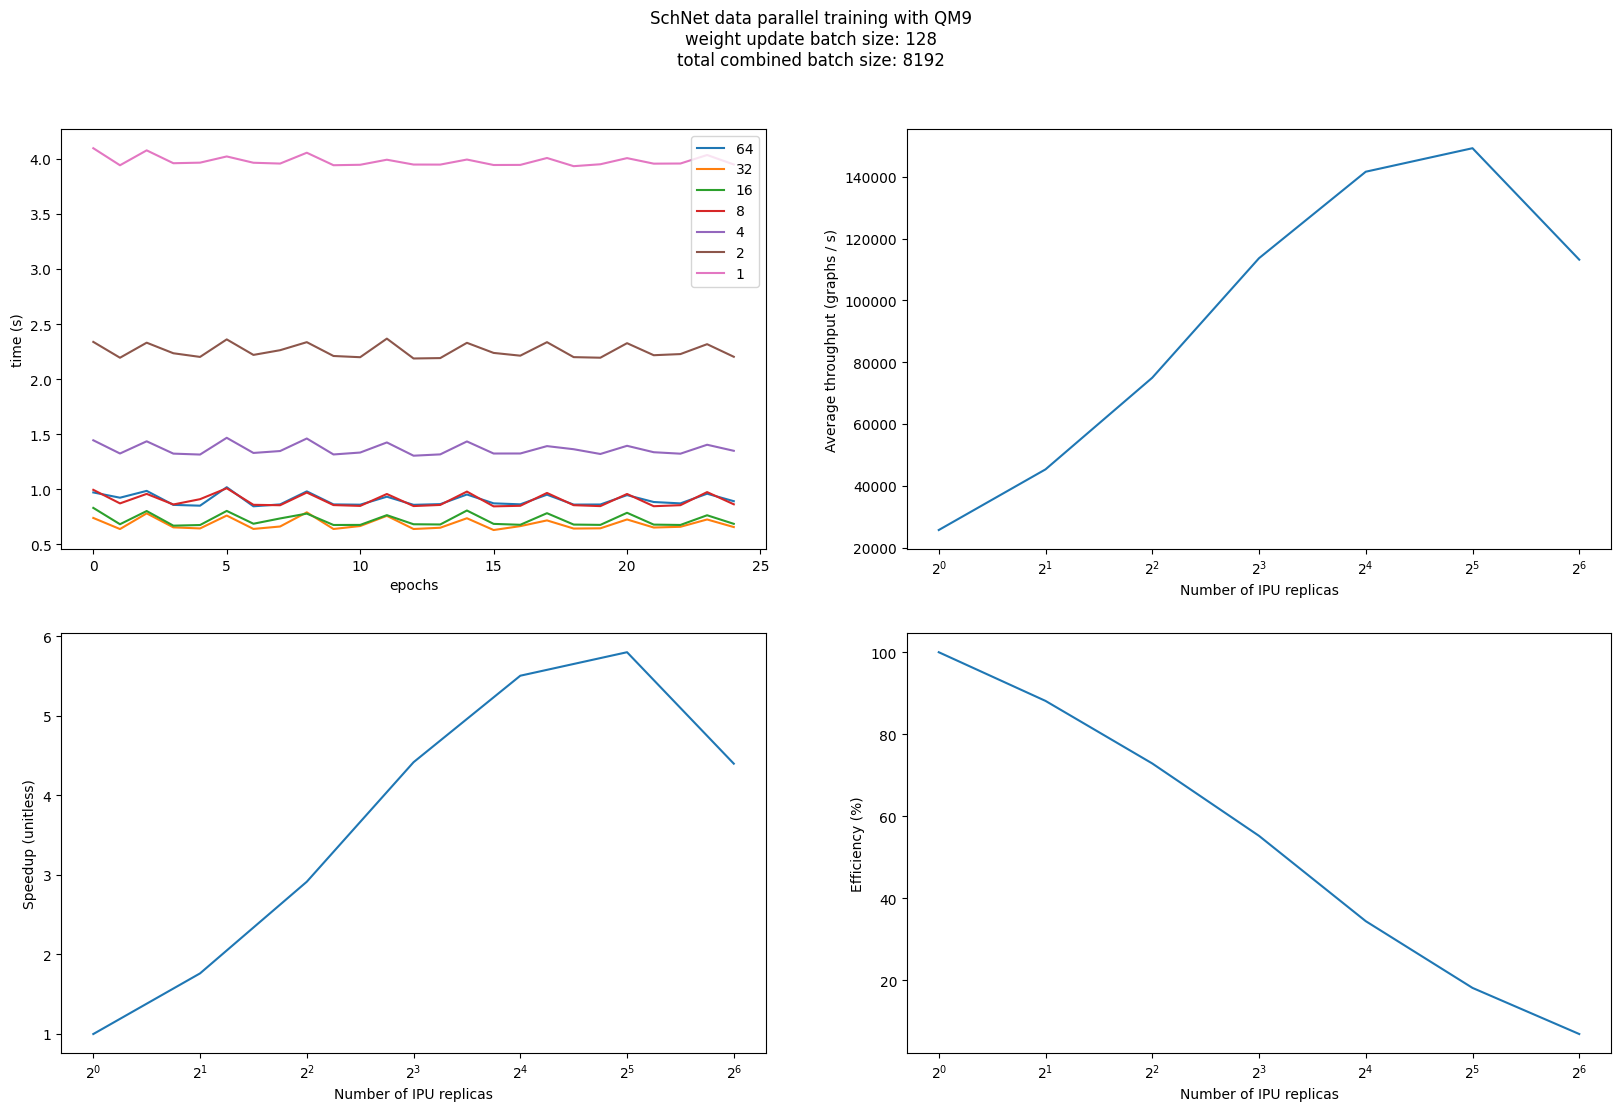

In [5]:
make_plots(df, throughput_df, "QM9")

## HydroNet Small (500 k) Packed

In [2]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-small-bow/sweeps/mg1a9mw5"
)
df

,64,32,16,8
0,1.162629,1.685666,2.934496,5.395554
1,4.945941,6.201504,6.376213,9.247392
2,4.798564,5.536353,6.396803,9.311887
3,3.689676,4.184623,5.448987,9.282788
4,4.763403,6.066579,6.390011,8.084242
5,4.917500,6.065773,6.472433,9.352262
6,3.602344,4.106822,5.355801,7.994203
7,4.990379,6.148584,6.578295,9.334779
8,3.564424,4.065853,5.305684,8.062193
9,4.968208,5.707876,6.535323,9.404596


In [4]:
throughput_df["mean_time"]

64    4.264129
32    4.702832
16    5.784758
8     8.614987
Name: mean_time, dtype: float64

In [8]:
loss_df

,64,32,16,8
0,75089.382812,60059.457031,52019.562500,49733.898438
1,52540.500000,48770.300781,47005.085938,46541.714844
2,49893.644531,47168.000000,46555.339844,46334.425781
3,48021.160156,46723.742188,46744.335938,46821.617188
4,47055.777344,46528.937500,47025.078125,46277.644531
5,46832.488281,46881.675781,46794.910156,46785.917969
6,46785.972656,47092.976562,46844.324219,47046.761719
7,46766.414062,46831.445312,46661.812500,47003.640625
8,46766.015625,46957.593750,46674.714844,46677.792969
9,46606.445312,46713.328125,46934.035156,46465.132812


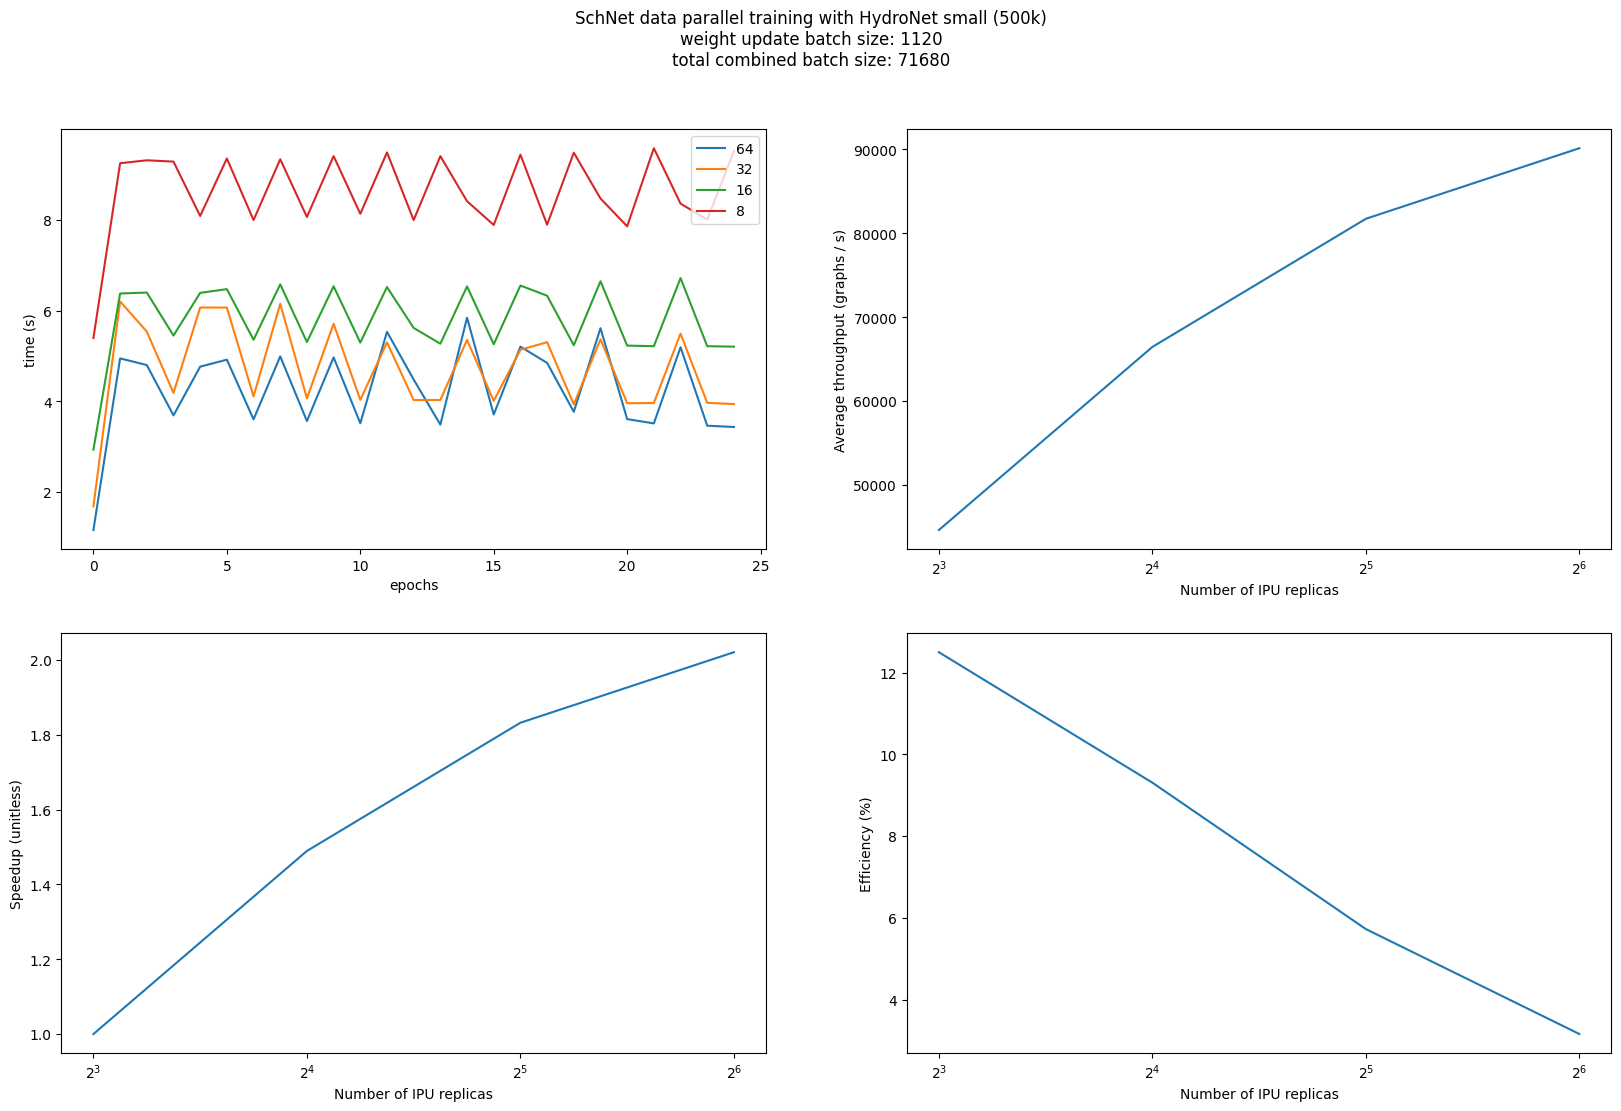

In [9]:
make_plots(df, throughput_df, "HydroNet small (500k)")

## HydroNet Medium (2.7m) Packed

In [5]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-medium-bow/sweeps/3o0l7xb2"
)
df

,64,32,16,8
0,12.415813,15.535437,22.204934,35.847813
1,11.814899,14.678098,21.071125,34.492274
2,12.203751,15.068091,21.704958,35.413248
3,11.361161,14.705295,20.873847,34.543874
4,11.572469,14.747307,21.428347,35.119688
5,12.015294,14.972679,21.467591,35.536425
6,11.982615,14.627768,21.337694,35.117668
7,11.307915,14.821437,20.898551,34.676010
8,11.538818,14.919519,21.487302,35.158036
9,11.292088,14.817927,20.847352,34.687714


In [7]:
throughput_df["mean_time"]

64    11.743593
32    14.810448
16    21.369961
8     35.077046
Name: mean_time, dtype: float64

In [12]:
loss_df

,64,32,16,8
0,53638.214844,49452.546875,47487.566406,46990.425781
1,46672.843750,46609.503906,46562.429688,46423.789062
2,46639.910156,46608.656250,46560.886719,46419.636719
3,46639.519531,46607.785156,46558.800781,46412.500000
4,46639.234375,46606.996094,46556.250000,46406.105469
5,46638.925781,46606.101562,46553.640625,46400.730469
6,46638.589844,46605.039062,46549.789062,46398.648438
7,46638.218750,46603.859375,46546.066406,46394.878906
8,46637.820312,46602.570312,46542.109375,46395.644531
9,46637.390625,46601.261719,46539.339844,46394.089844


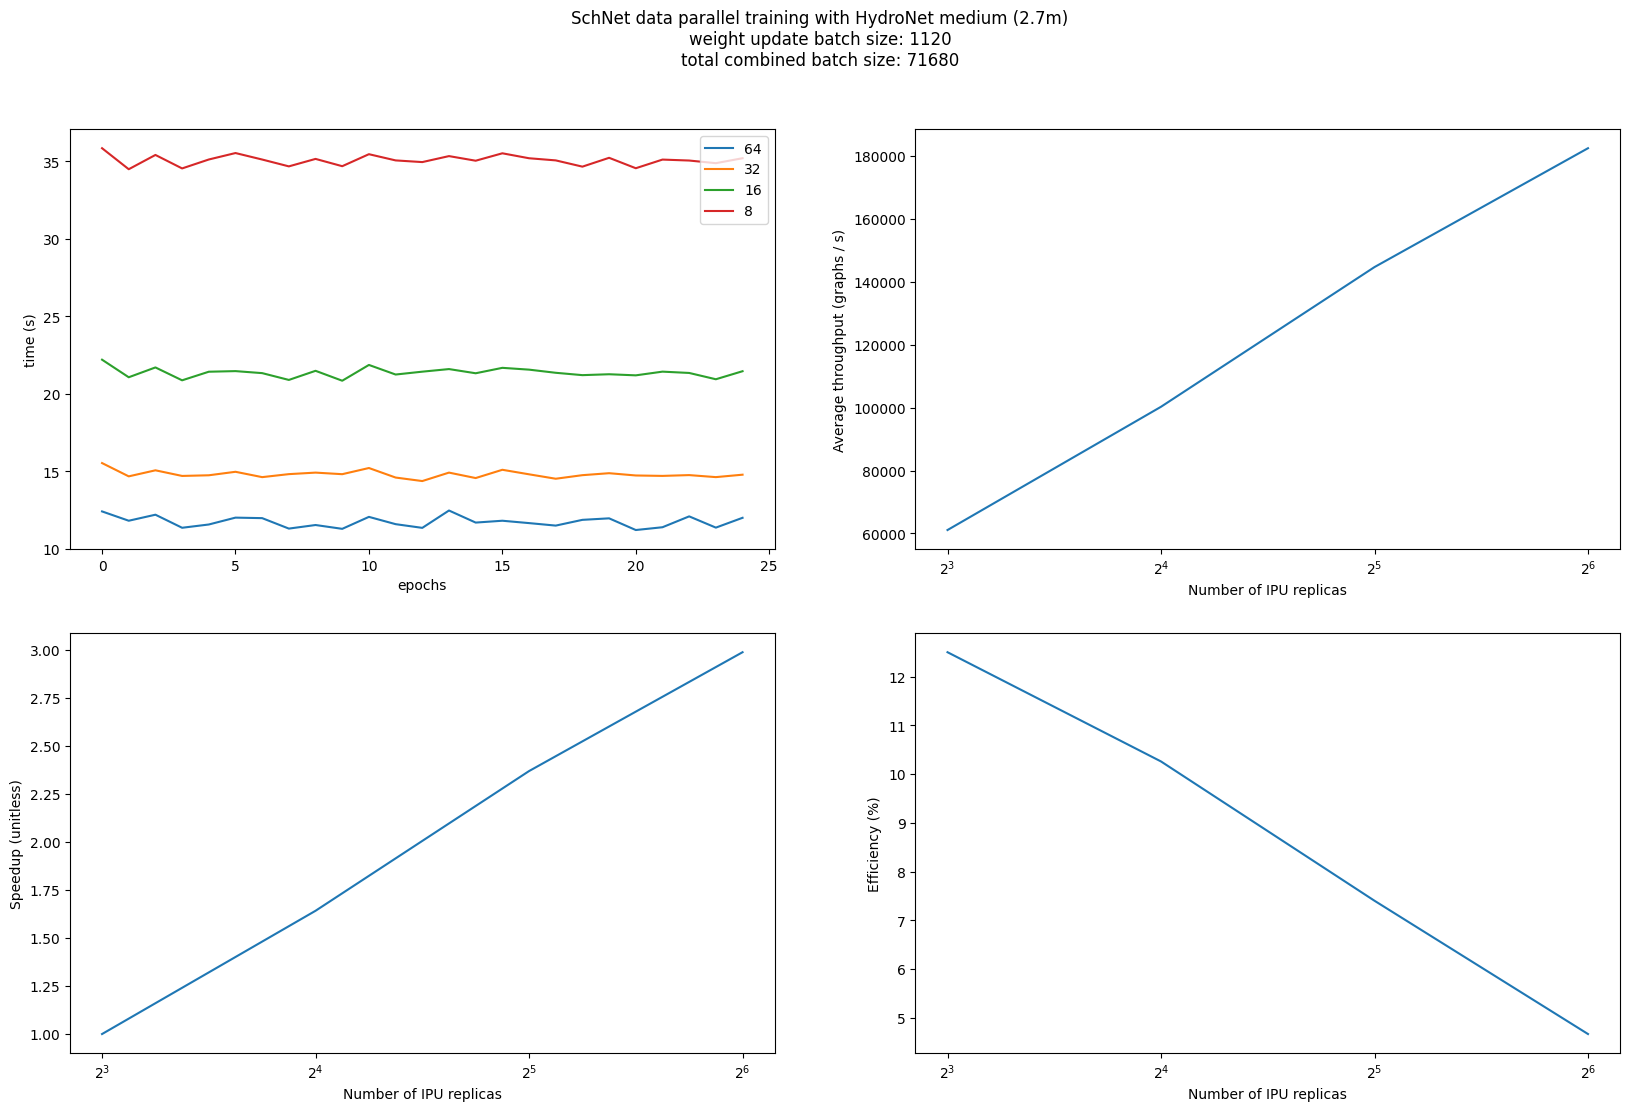

In [13]:
make_plots(df, throughput_df, "HydroNet medium (2.7m)")

## HydroNet (4.5m) Packed

In [8]:
# df, throughput_df, loss_df = sweep_dataframe("hatemh/hydronet-large-bow/sweeps/jr3w2gz9")
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-large-bow-sync/sweeps/rssyv7co"
)
df

,64,32,16,8
0,21.230924,24.935567,36.238546,61.234170
1,24.496263,27.156519,39.561248,65.042791
2,25.050624,28.085414,39.209612,66.319189
3,23.529100,27.314333,40.268040,66.156070
4,21.938736,25.324083,35.845708,62.901006
5,18.403032,23.821707,36.777892,62.520862
6,30.527840,30.315185,47.367176,74.206502
7,20.533349,22.559508,34.353478,59.522924
8,21.266339,25.843028,38.641707,63.586195
9,20.114902,22.127926,33.874340,59.857613


In [10]:
throughput_df["mean_time"]

64    21.871910
32    26.095291
16    38.415614
8     63.112137
Name: mean_time, dtype: float64

In [16]:
loss_df

,64,32,16,8
0,67514.070312,67354.382812,67120.859375,67003.031250
1,67224.640625,67146.132812,67205.109375,67091.804688
2,67249.757812,67060.820312,66874.289062,66682.328125
3,67179.679688,66966.031250,66775.929688,66499.593750
4,67137.796875,66942.617188,66727.257812,66426.351562
5,67127.781250,66950.312500,66814.132812,66681.070312
6,67101.148438,66934.671875,66670.890625,66535.578125
7,67026.695312,66831.984375,66656.726562,66790.070312
8,66942.476562,66719.789062,66557.046875,66475.500000
9,67004.929688,66812.796875,66606.703125,66484.257812


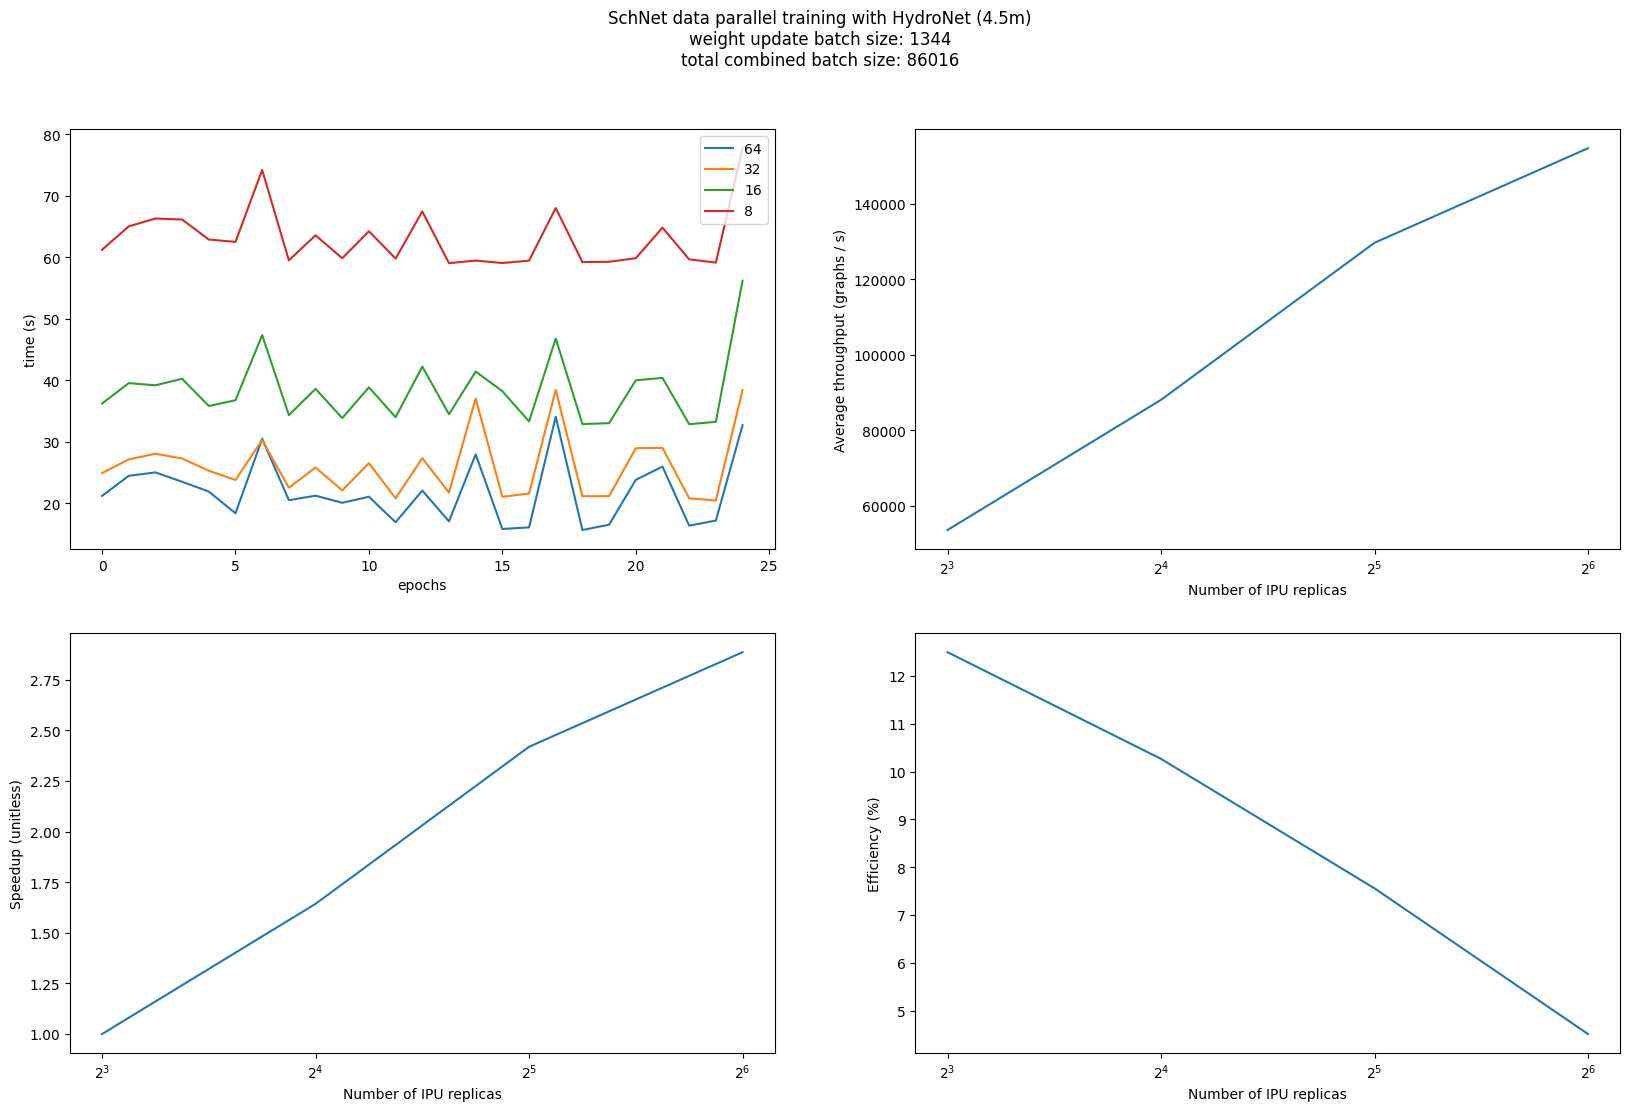

In [17]:
make_plots(df, throughput_df, "HydroNet (4.5m)")

## QM9 Synthetic Data

In [18]:
df, throughput_df, _ = sweep_dataframe("hatemh/qm9-bow-synthetic/sweeps/937n4bw2")
df

,64,32,16,8,4,2,1
0,0.091733,0.136308,0.247976,0.471027,0.923020,1.808455,3.569390
1,0.089734,0.138022,0.245902,0.468940,0.922559,1.796710,3.547026
2,0.089954,0.135770,0.249285,0.469787,0.918822,1.792257,3.546456
3,0.089197,0.135385,0.245703,0.470027,0.913604,1.794218,3.546204
4,0.089792,0.136666,0.245109,0.470311,0.913859,1.792305,3.547342
5,0.089515,0.135294,0.244708,0.465240,0.914285,1.792084,3.546943
6,0.090208,0.136401,0.245528,0.465199,0.913928,1.792643,3.547080
7,0.089555,0.135525,0.244808,0.465278,0.913586,1.793834,3.546718
8,0.089561,0.135961,0.245017,0.465257,0.914153,1.792388,3.546571
9,0.093086,0.136716,0.246019,0.465626,0.913795,1.791533,3.547557


In [19]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,0.090179,102400,1.135514e+06,39.318926,61.435821
32,0.135968,102400,7.531166e+05,26.077824,81.493199
16,0.244324,102400,4.191152e+05,14.512511,90.703196
8,0.466661,102400,2.194313e+05,7.598146,94.976822
4,0.915102,102400,1.119001e+05,3.874713,96.867820
2,1.793132,102400,5.710679e+04,1.977411,98.870530
1,3.545758,102400,2.887958e+04,1.000000,100.000000


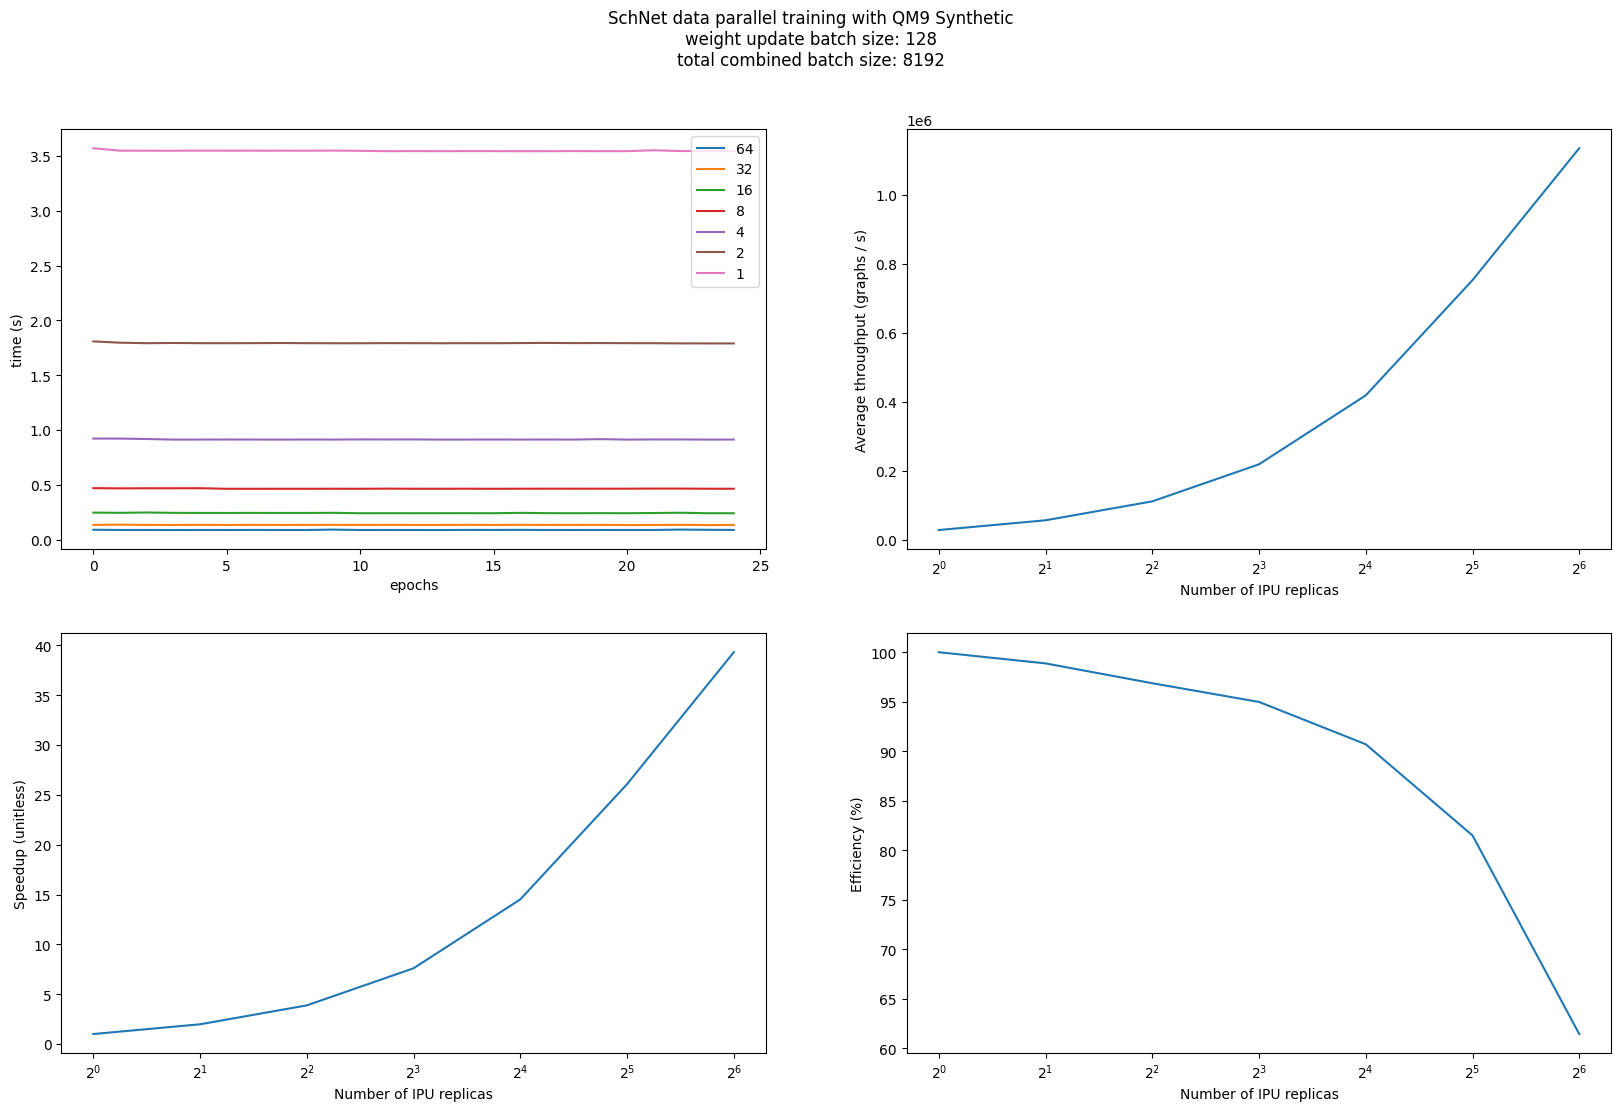

In [20]:
make_plots(df, throughput_df, "QM9 Synthetic")

## HydroNet Small Synthetic

In [21]:
df, throughput_df, _ = sweep_dataframe(
    "hatemh/hydronet-small-bow-synthetic/sweeps/g5g6z3dh"
)
df

,64,32,16,8
0,0.626760,1.242532,2.457896,4.905159
1,0.626882,1.235729,2.458610,4.905109
2,0.626573,1.237931,2.461902,4.906076
3,0.626680,1.238660,2.460364,4.906551
4,0.627005,1.238557,2.459237,4.907108
5,0.628595,1.237458,2.459566,4.905668
6,0.626855,1.237331,2.459580,4.905826
7,0.626788,1.237168,2.458390,4.905448
8,0.627100,1.237001,2.458263,4.905484
9,0.626718,1.236975,2.460053,4.905750


In [22]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,0.627074,384383,612978.988063,7.822418,12.222527
32,1.237447,384383,310625.865070,3.963994,12.387482
16,2.459235,384383,156301.858235,1.994617,12.466357
8,4.905232,384383,78361.834610,1.000000,12.500000


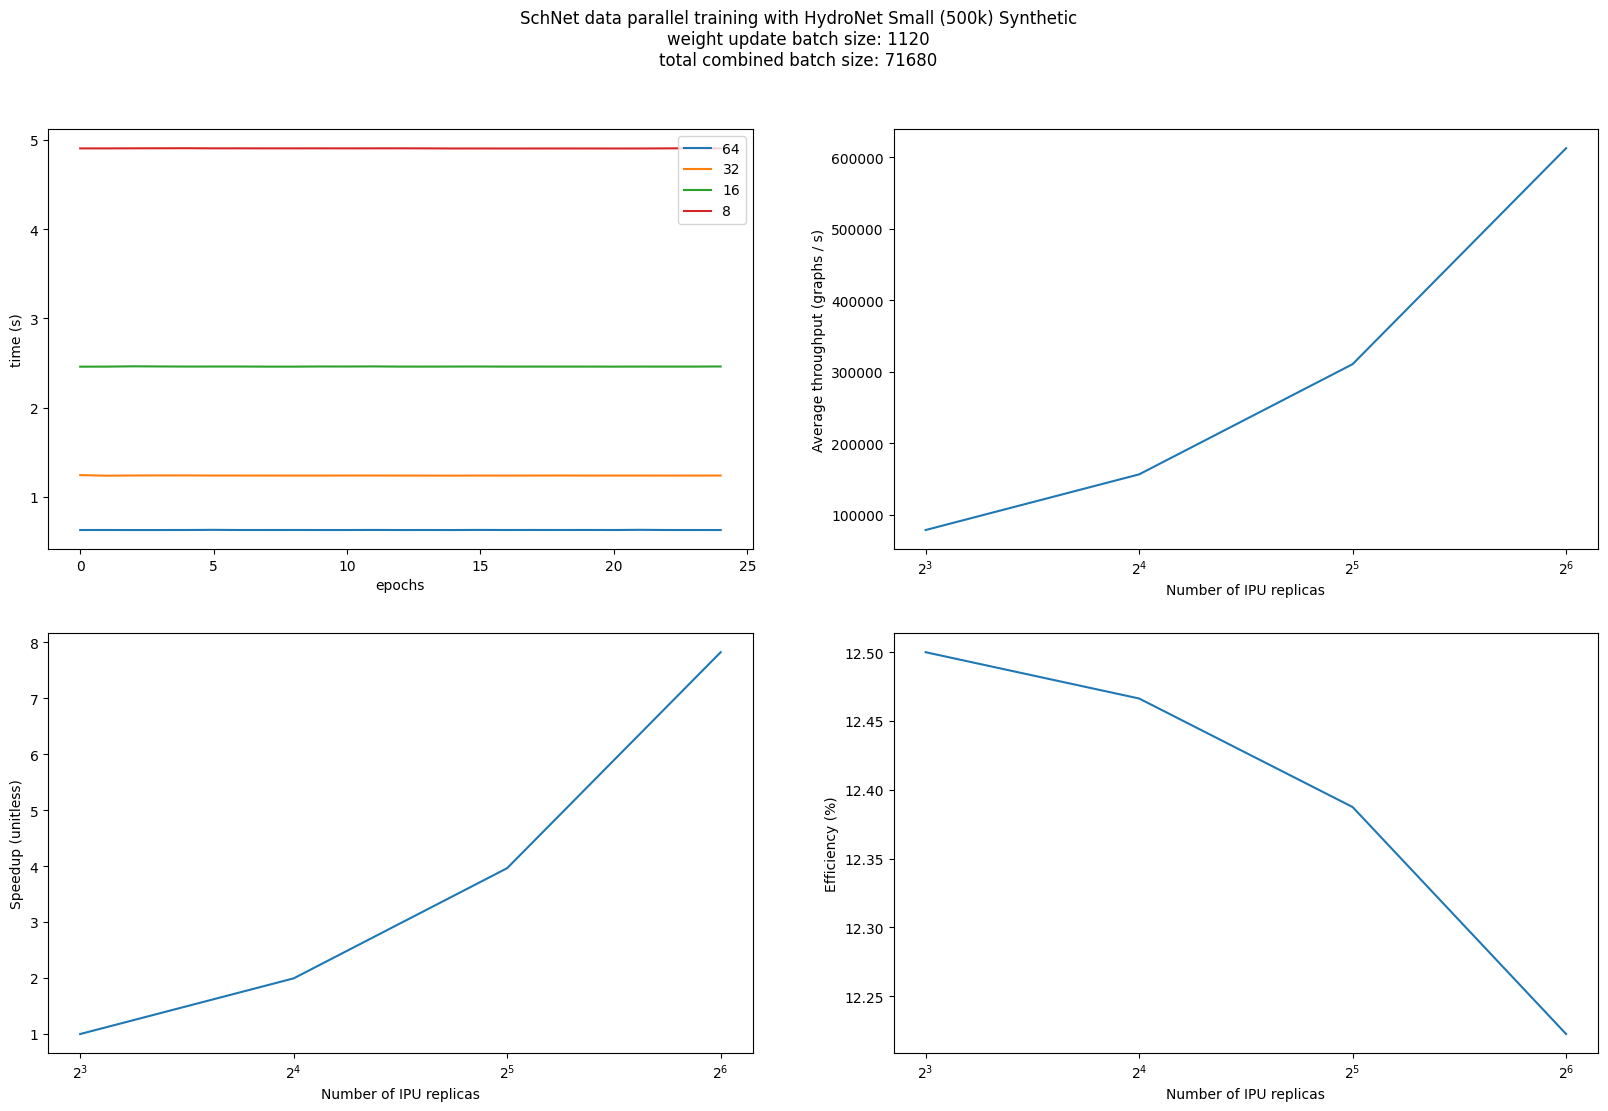

In [23]:
make_plots(df, throughput_df, "HydroNet Small (500k) Synthetic")

## HydroNet Medium (2.7m) Synthetic

In [24]:
df, throughput_df, _ = sweep_dataframe(
    "hatemh/hydronet-small-bow-synthetic/sweeps/g5g6z3dh"
)
df

,64,32,16,8
0,0.626760,1.242532,2.457896,4.905159
1,0.626882,1.235729,2.458610,4.905109
2,0.626573,1.237931,2.461902,4.906076
3,0.626680,1.238660,2.460364,4.906551
4,0.627005,1.238557,2.459237,4.907108
5,0.628595,1.237458,2.459566,4.905668
6,0.626855,1.237331,2.459580,4.905826
7,0.626788,1.237168,2.458390,4.905448
8,0.627100,1.237001,2.458263,4.905484
9,0.626718,1.236975,2.460053,4.905750


In [25]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,0.627074,384383,612978.988063,7.822418,12.222527
32,1.237447,384383,310625.865070,3.963994,12.387482
16,2.459235,384383,156301.858235,1.994617,12.466357
8,4.905232,384383,78361.834610,1.000000,12.500000


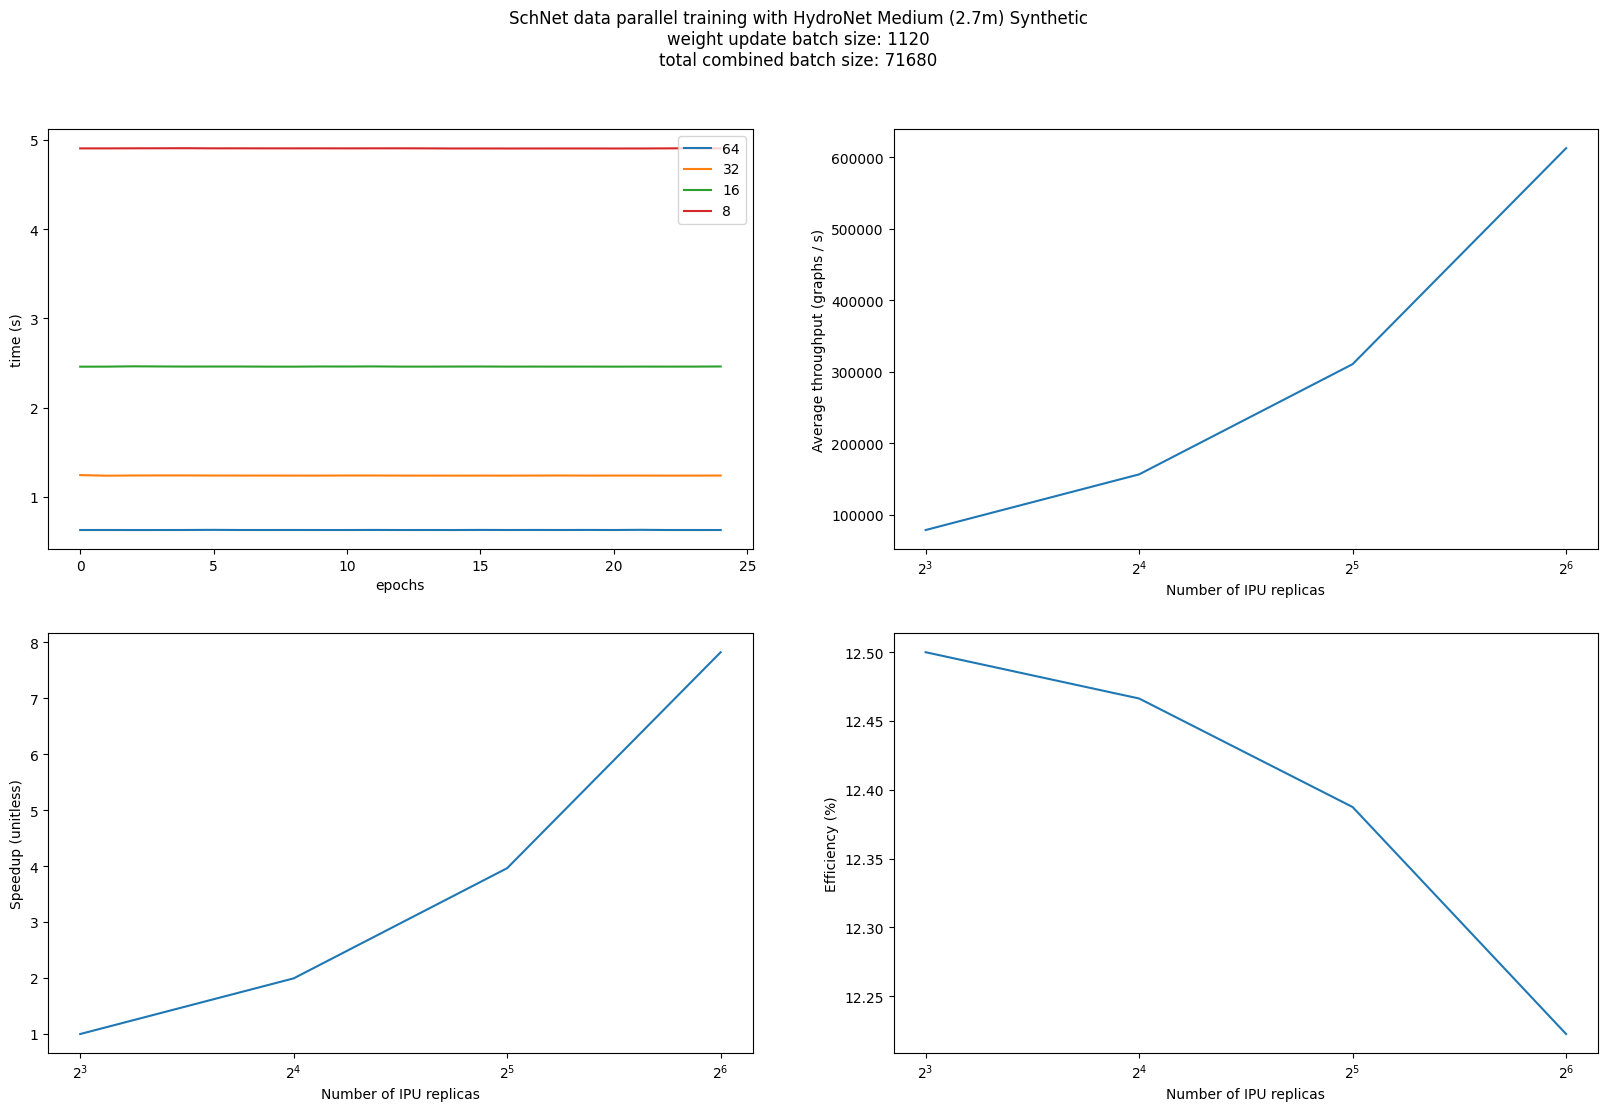

In [26]:
make_plots(df, throughput_df, "HydroNet Medium (2.7m) Synthetic")

## QM9 Padded

In [27]:
df, throughput_df, loss_df = sweep_dataframe("hatemh/qm9-bow-padding/sweeps/2dzlfxw3")
df

,64,32,16,8,4,2,1
0,1.390869,0.764153,0.819200,1.153253,2.022837,3.704541,7.132200
1,1.570473,1.209890,1.030170,1.498278,2.269618,3.860658,7.257104
2,1.727744,1.151071,1.148482,1.513575,2.293184,3.925431,7.321582
3,1.581753,1.117720,1.089980,1.487120,2.273852,3.913933,7.283247
4,1.764570,1.109436,1.167274,1.710622,2.325956,3.869476,7.260355
5,1.766445,1.186237,1.185217,1.591438,2.298688,3.976687,7.381777
6,1.571944,1.104063,1.082586,1.491456,2.229012,3.935819,7.350036
7,1.594937,1.137597,1.029768,1.545581,2.203609,3.905586,7.256406
8,1.684395,1.250373,1.173438,1.584099,2.385170,4.060437,7.379509
9,1.540449,1.071645,1.036435,1.476699,2.223518,3.917004,7.320422


In [28]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,1.605047,104448,65074.724496,4.555970,7.118703
32,1.156191,104448,90338.019833,6.324687,19.764648
16,1.098560,104448,95077.204046,6.656484,41.603025
8,1.530112,104448,68261.650564,4.779091,59.738634
4,2.272508,104448,45961.545167,3.217830,80.445752
2,3.947066,104448,26462.189462,1.852654,92.632688
1,7.312546,104448,14283.397187,1.000000,100.000000


In [29]:
loss_df

,64,32,16,8,4,2,1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


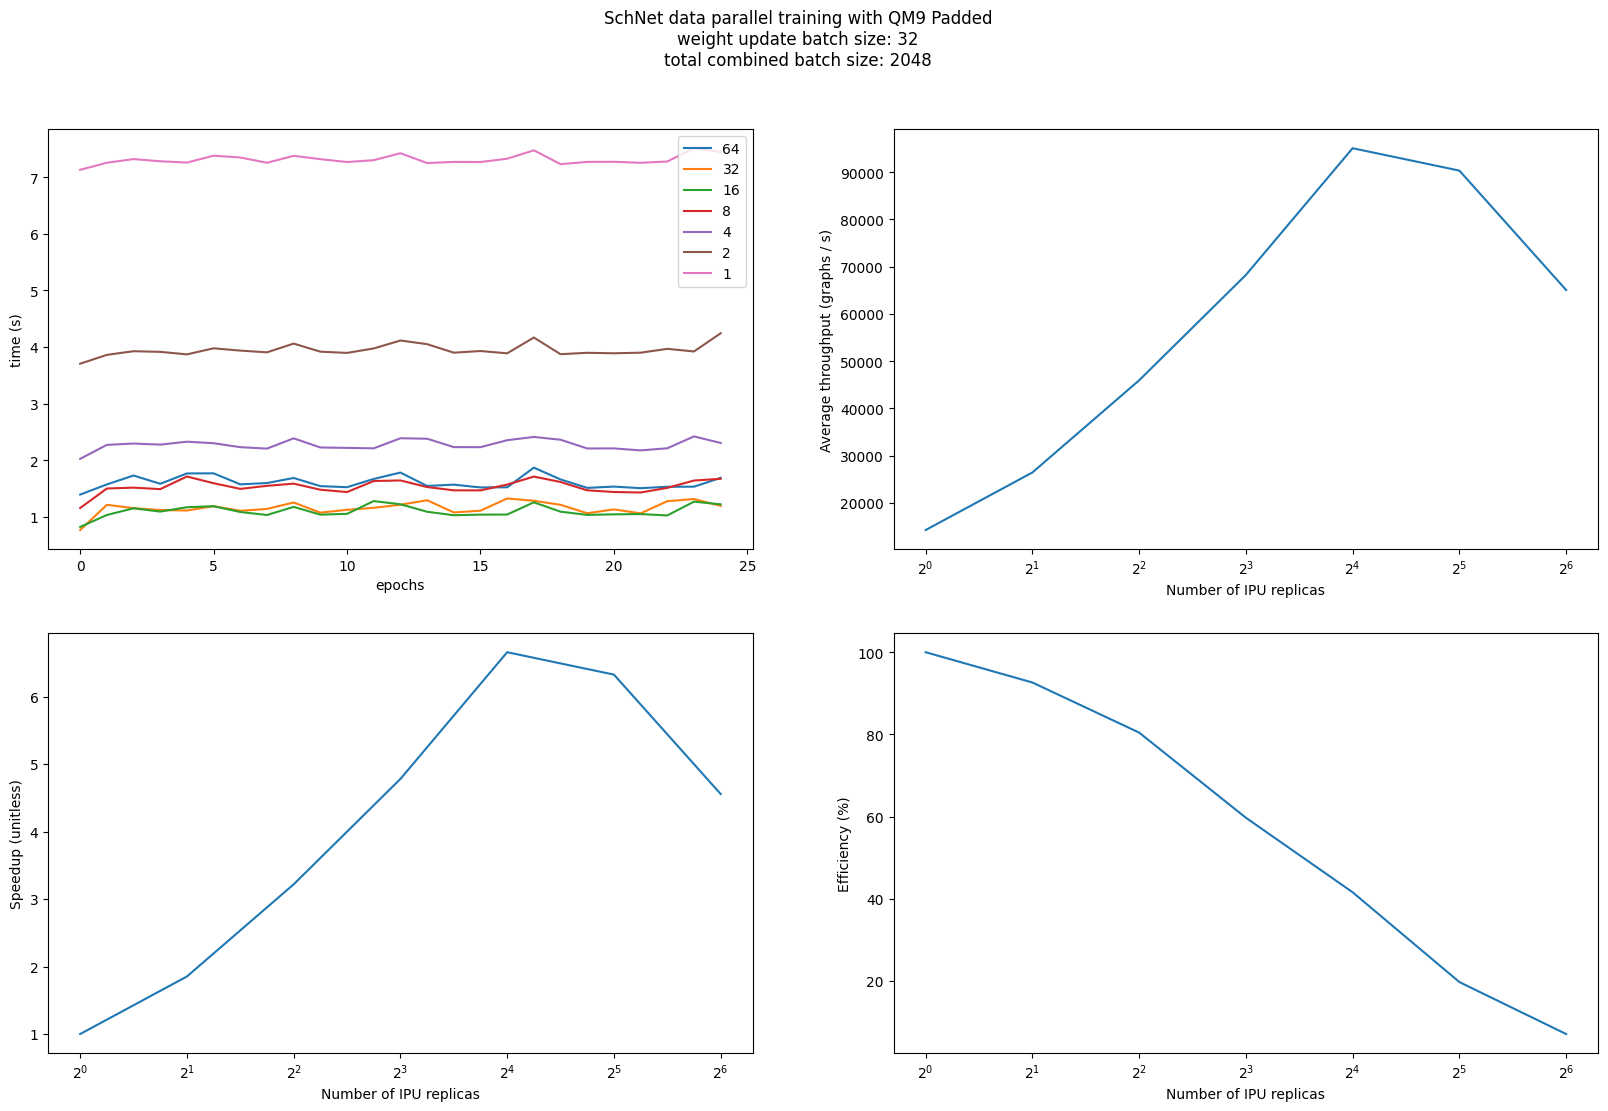

In [30]:
make_plots(df, throughput_df, "QM9 Padded")

## HydroNet Small (500k) Padded

In [31]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-small-padding/sweeps/ar474kwz"
)
df

,64,32,16,8
0,1.338460,2.032264,3.817484,7.295134
1,5.388892,6.301983,7.702636,11.172987
2,4.550820,5.516684,6.985441,10.533329
3,5.204320,6.000678,7.540332,11.171498
4,5.058208,6.125599,7.474815,10.241063
5,5.202422,5.395909,6.815507,10.918983
6,5.079396,5.977411,7.448771,11.106200
7,4.098215,5.031462,6.543461,10.074226
8,4.123844,5.013987,6.479019,9.972753
9,5.130055,5.921739,7.361795,10.849599


In [32]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,4.257973,372736,87538.375707,2.362770,3.691828
32,5.092207,372736,73197.331740,1.975688,6.174024
16,6.584223,372736,56610.480167,1.527988,9.549923
8,10.060611,372736,37049.042870,1.000000,12.500000


In [33]:
loss_df

,64,32,16,8
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


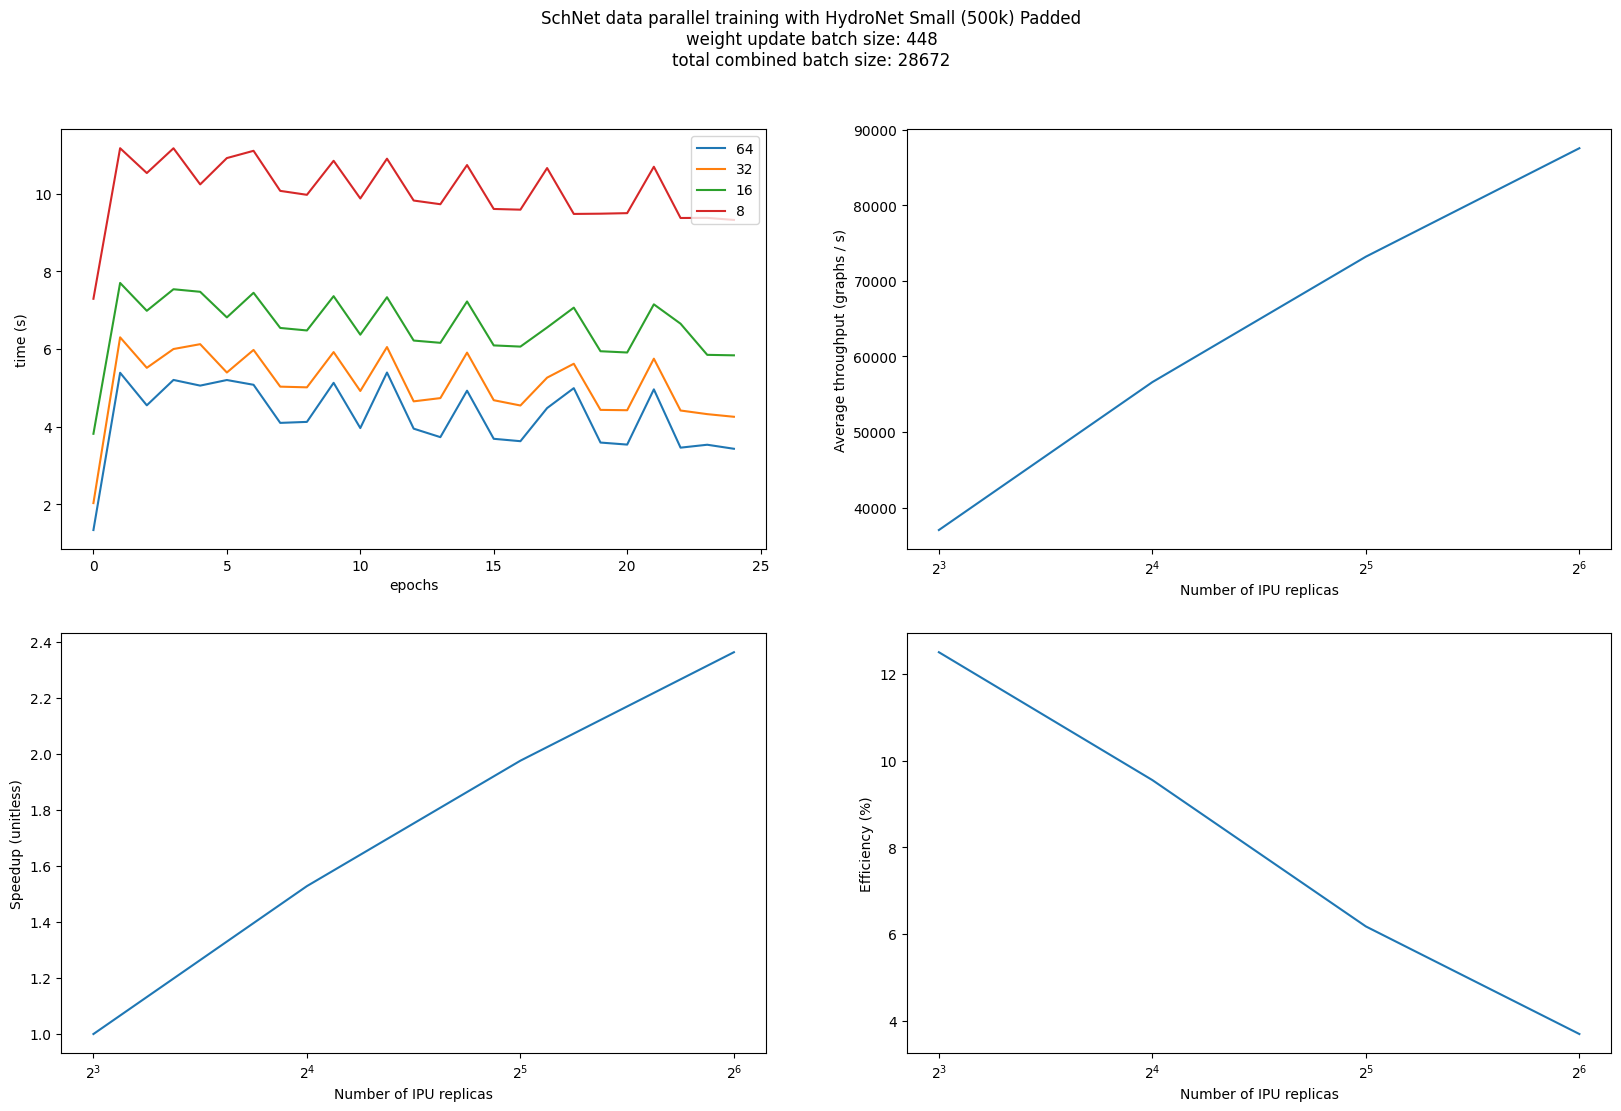

In [34]:
make_plots(df, throughput_df, "HydroNet Small (500k) Padded")

## HydroNet Medium (2.7m) Padded

In [35]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-medium-padded/sweeps/7iqth0yo"
)
df

,64,32,16,8
0,8.013101,11.412952,21.051649,41.081737
1,17.490364,17.131173,27.247790,45.237389
2,18.329337,18.259324,28.715768,47.782035
3,17.093951,18.995416,27.913957,45.632426
4,16.878778,17.454188,27.011868,47.261198
5,17.064189,16.535356,26.143031,45.824244
6,17.294874,18.649687,28.682774,50.233845
7,18.529227,20.359943,28.190521,45.802012
8,15.677940,17.438657,27.543868,46.613345
9,17.959323,19.044848,32.000642,46.064401


In [36]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,15.738043,2179072,138458.888446,2.935685,4.587009
32,17.617006,2179072,123691.394757,2.622577,8.195552
16,27.246634,2179072,79975.822942,1.695694,10.598086
8,46.201946,2179072,47164.074259,1.000000,12.500000


In [37]:
loss_df

,64,32,16,8
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


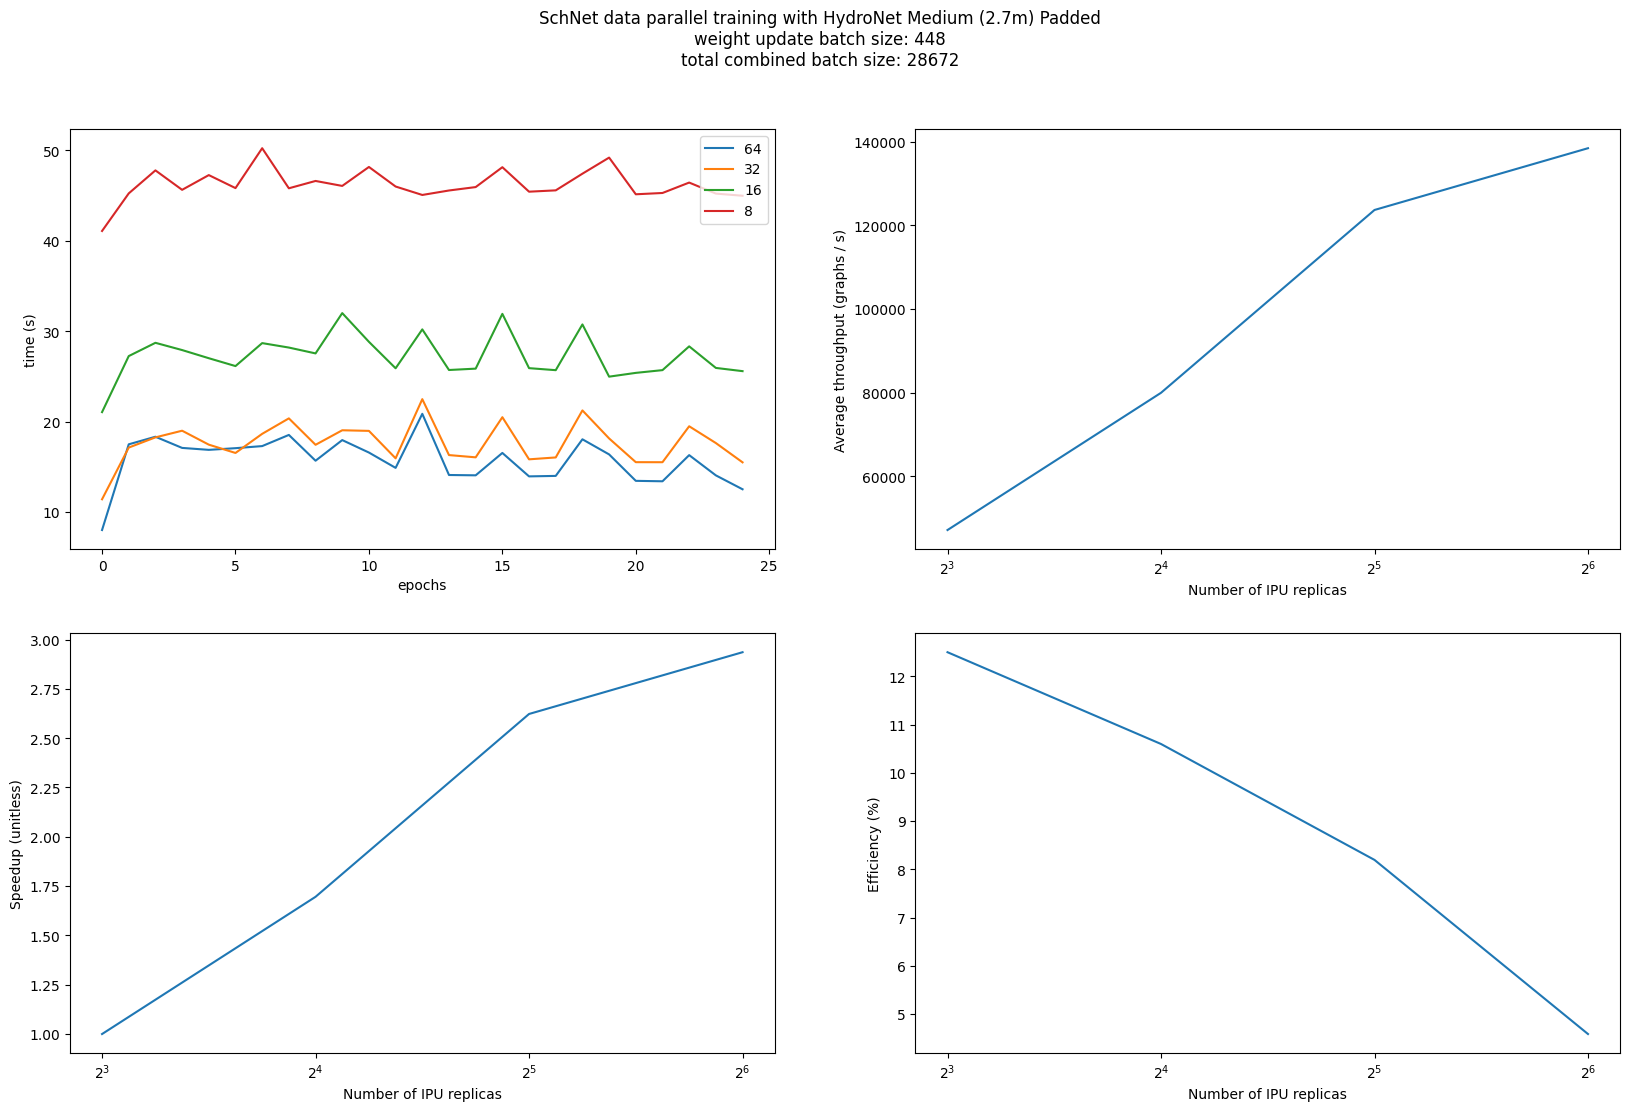

In [38]:
make_plots(df, throughput_df, "HydroNet Medium (2.7m) Padded")

## HydroNet (4.5m) Padded

In [39]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-large-padded/sweeps/0jj9nion"
)
df

,64,32,16,8
0,14.036363,19.747790,36.014957,67.489348
1,22.470023,24.439553,39.969022,70.761522
2,23.611501,25.725781,39.790951,71.034132
3,23.500618,25.528713,37.970087,71.780837
4,20.115549,22.218890,37.849291,70.431346
5,26.587825,25.632175,40.139673,74.738173
6,24.824247,26.396162,38.366036,70.573662
7,19.395503,22.250812,41.650762,70.100110
8,23.312553,31.793320,44.485323,72.215470
9,19.171032,22.044623,37.938616,69.995248


In [40]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,21.484225,3555328,165485.516306,3.312412,5.175644
32,26.024810,3555328,136613.025772,2.734491,8.545284
16,40.548009,3555328,87681.937308,1.755070,10.969190
8,71.164608,3555328,49959.215709,1.000000,12.500000


In [41]:
loss_df

,64,32,16,8
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


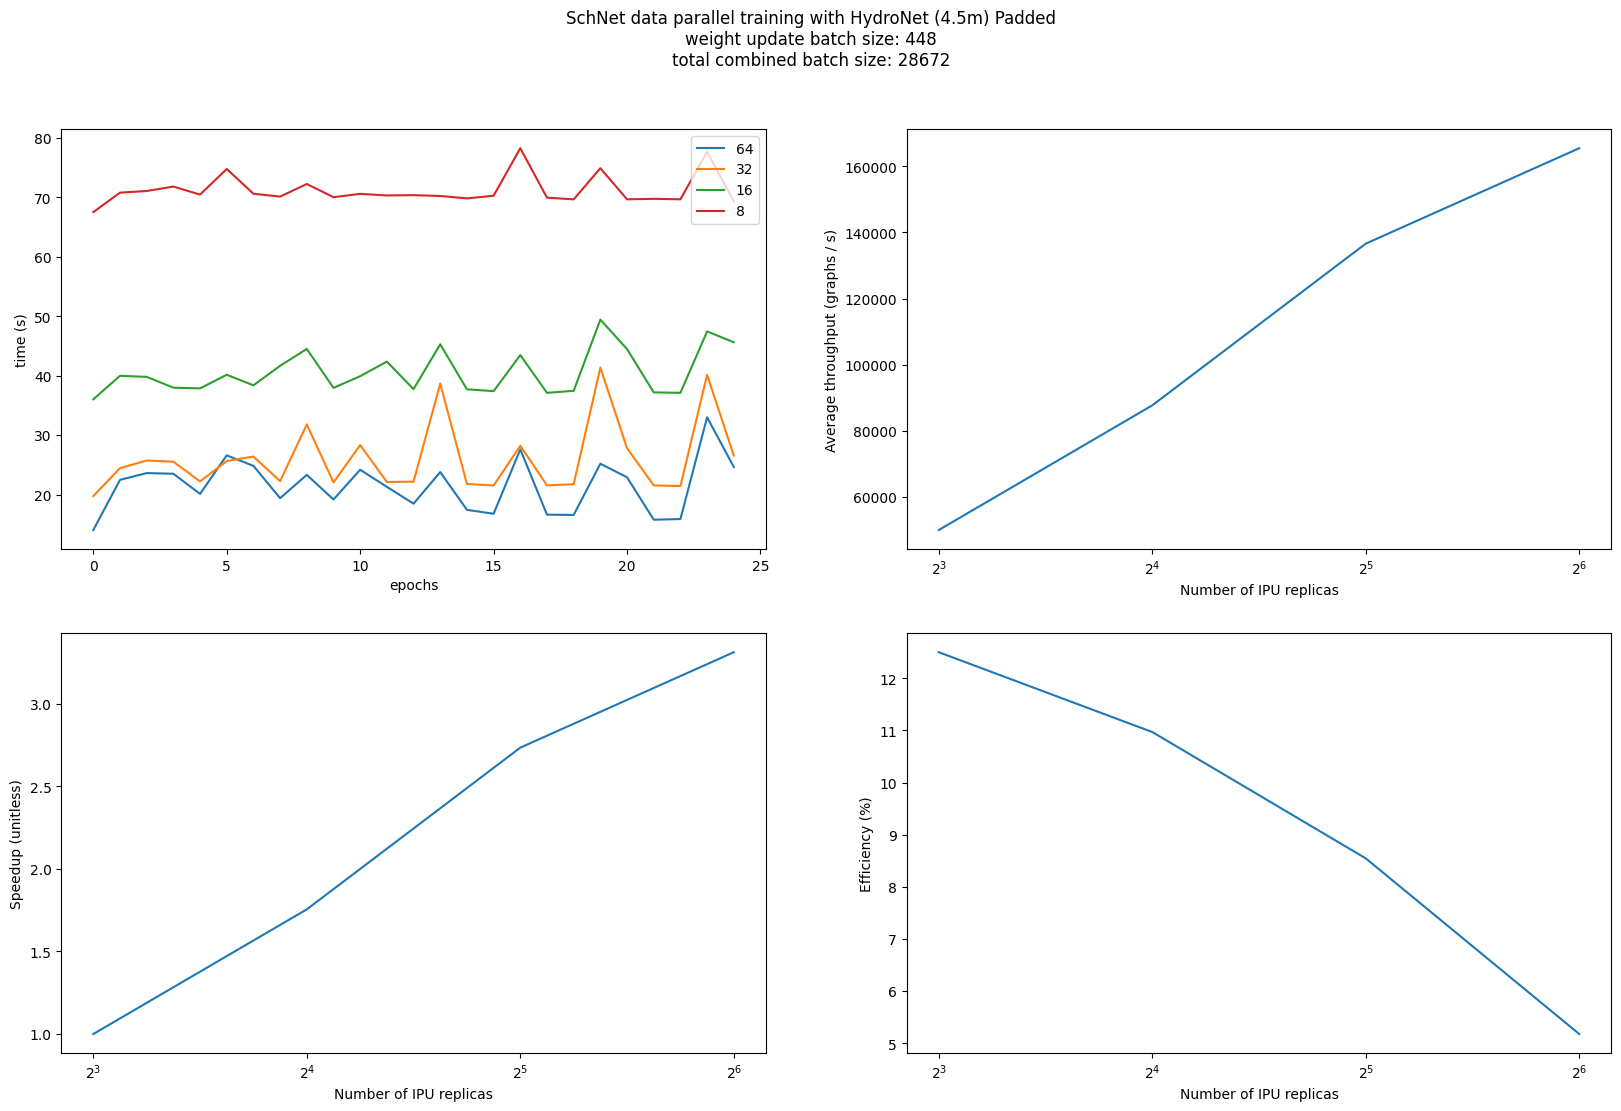

In [42]:
make_plots(df, throughput_df, "HydroNet (4.5m) Padded")

## QM9 Packed with Synchronous Data Loading

In [43]:
df, throughput_df, loss_df = sweep_dataframe("hatemh/qm9-bow-sync/sweeps/26udcs8p")
df

,64,32,16,8,4,2,1
0,1.486319,1.268652,1.266628,1.477650,1.694254,2.704861,4.412458
1,1.113149,0.896473,0.878897,1.071092,1.370838,2.326494,4.011000
2,1.407172,1.208300,1.219048,1.522455,1.546012,2.698304,4.328597
3,1.093778,0.975442,0.974377,1.097308,1.522428,2.547734,4.136720
4,0.998307,0.863793,0.875469,1.056368,1.352673,2.293470,3.978860
5,1.558324,1.365888,1.320151,1.512561,1.659976,2.630369,4.488516
6,1.173867,0.836438,1.000672,1.166374,1.513265,2.540793,4.234079
7,1.104484,0.852945,0.854602,0.995725,1.367780,2.352931,4.088676
8,1.364580,1.319634,1.223685,1.458202,1.595637,2.574327,4.164890
9,1.297578,1.168906,1.130838,1.286821,1.585496,2.567012,4.362222


In [44]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,1.173582,102400,87254.257649,3.560608,5.563450
32,1.016444,102400,100743.359680,4.111061,12.847066
16,1.006905,102400,101697.754412,4.150007,25.937546
8,1.188401,102400,86166.198630,3.516207,43.952588
4,1.479165,102400,69228.245584,2.825015,70.625386
2,2.462251,102400,41587.956718,1.697091,84.854541
1,4.178664,102400,24505.439617,1.000000,100.000000


In [45]:
loss_df

,64,32,16,8,4,2,1
0,81.962013,41.773537,32.961014,23.730852,18.157177,17.351660,17.285305
1,21.087910,17.357624,17.080782,17.054899,17.058605,17.194738,17.561192
2,17.520428,17.100300,17.058180,17.048388,17.055336,17.382666,17.190029
3,17.194012,17.079456,17.056311,17.064991,17.098289,17.372562,17.304834
4,17.116707,17.052685,17.045933,17.056467,17.332909,17.246906,17.202019
5,17.105730,17.066317,17.060318,17.058914,17.303102,17.398909,17.183182
6,17.078461,17.066177,17.083532,17.096088,17.347715,17.298241,17.239977
7,17.066719,17.038134,17.041437,17.070280,17.379641,17.268316,17.169300
8,17.060524,17.051535,17.050434,17.244778,17.424589,17.256626,17.141809
9,17.063662,17.053614,17.057165,17.324291,17.319136,17.246769,17.232361


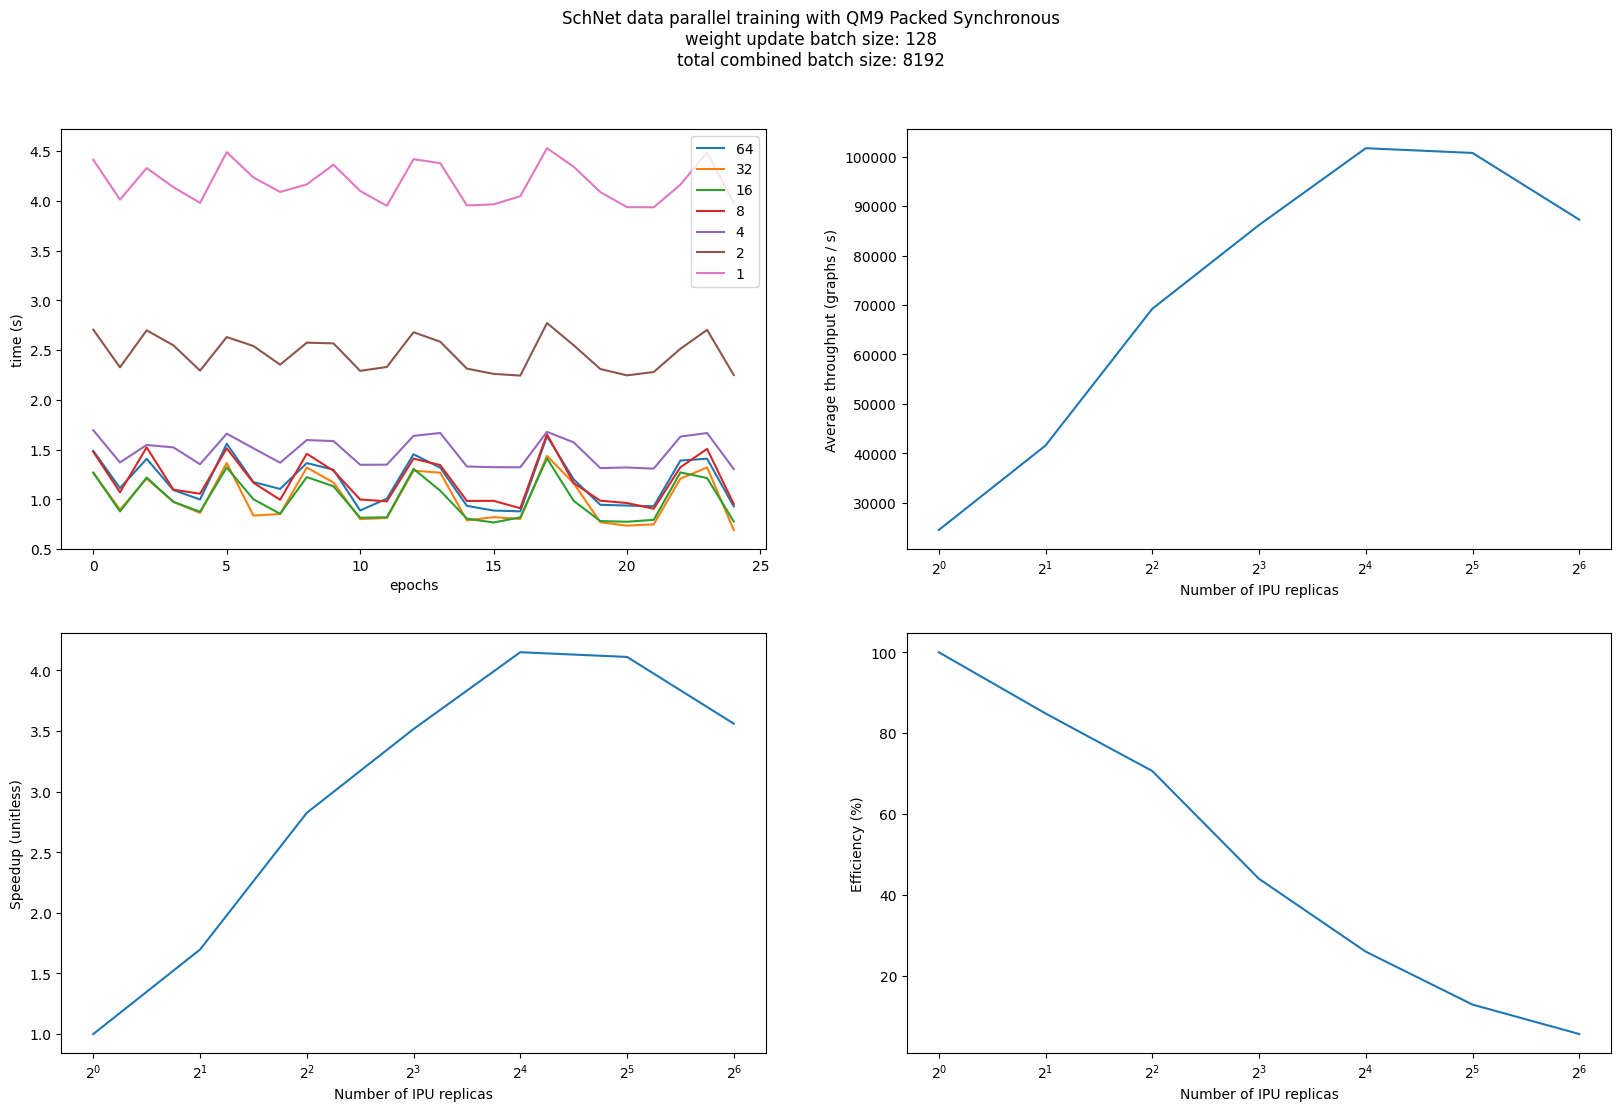

In [46]:
make_plots(df, throughput_df, "QM9 Packed Synchronous")

## HydroNet Small (500k) with Synchronous Data Loading

In [47]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-small-bow-sync/sweeps/tu7of7kv"
)
df

,64,32,16,8
0,4.750299,5.420039,6.575885,9.006877
1,4.856079,5.463071,6.617774,8.847579
2,4.909507,5.607497,6.660922,8.892683
3,4.885314,5.539473,6.666272,8.931162
4,4.665095,5.068761,5.539939,7.884602
5,4.893580,5.636162,6.691893,9.256139
6,3.751841,4.220026,5.498159,8.183662
7,4.923705,5.643345,6.676849,9.278729
8,4.320374,4.673957,5.483489,7.896112
9,4.942650,6.694327,6.768665,9.171170


In [48]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,4.641576,384381,82812.612180,1.818008,2.840637
32,5.276709,384381,72844.834986,1.599182,4.997445
16,6.178940,384381,62208.246044,1.365674,8.535465
8,8.438419,384381,45551.302695,1.000000,12.500000


In [49]:
loss_df

,64,32,16,8
0,49771.632812,49397.566406,47254.867188,46943.976562
1,48118.964844,47054.382812,46716.808594,46714.484375
2,47064.808594,46698.492188,46632.367188,46700.953125
3,46981.320312,46759.519531,46694.601562,46777.328125
4,46859.164062,46640.152344,46507.703125,46425.796875
5,46914.046875,46714.476562,46619.046875,46601.027344
6,46758.105469,46737.082031,46678.816406,46715.812500
7,46687.746094,46639.945312,46701.171875,46783.796875
8,46704.714844,46737.796875,46693.781250,46928.707031
9,46764.863281,46614.988281,46616.011719,46475.863281


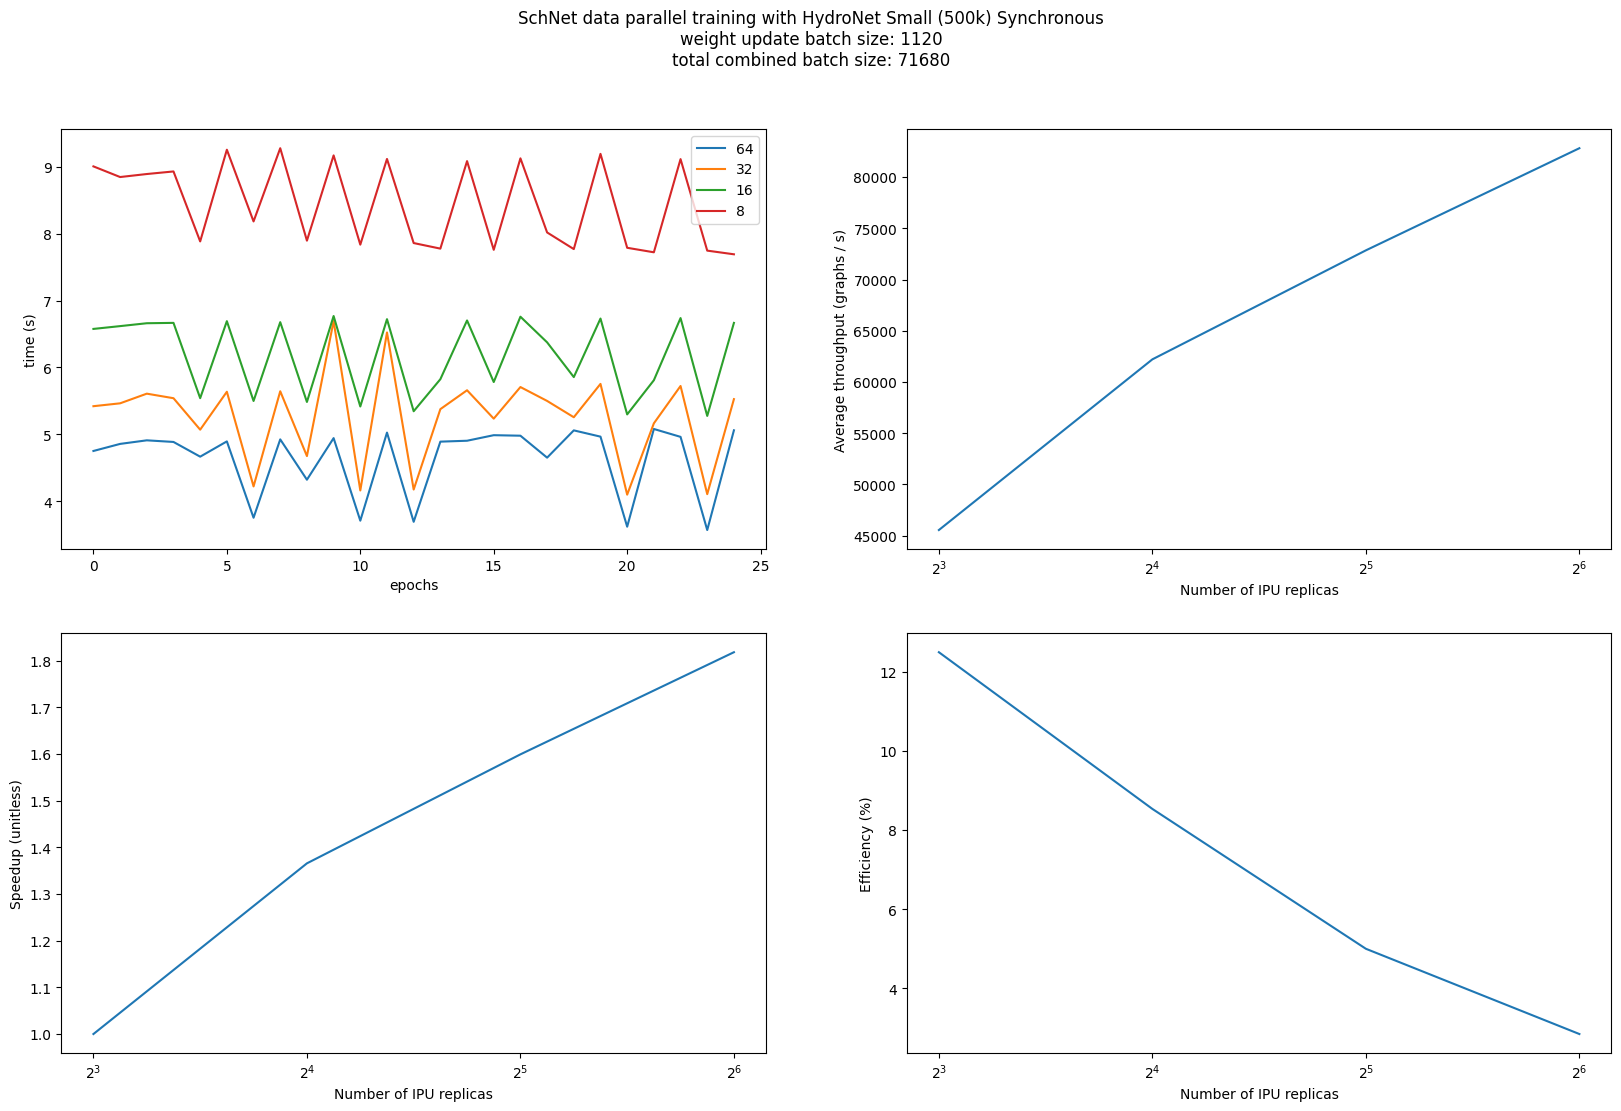

In [50]:
make_plots(df, throughput_df, "HydroNet Small (500k) Synchronous")

## HydroNet Medium (2.7m) with Synchronous Data Loading

In [51]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-medium-bow-sync/sweeps/f97p72yr"
)
df

,64,32,16,8
0,11.853109,14.668662,21.013263,35.348014
1,11.915324,14.862373,21.406597,35.223547
2,11.377385,14.842857,22.331546,34.732806
3,12.257243,15.379042,21.606418,35.448655
4,13.192087,16.165692,22.034132,35.899545
5,11.846587,15.177675,21.374415,35.578531
6,13.015278,15.407057,22.275574,35.443298
7,13.649079,16.151555,21.386536,37.258674
8,13.442701,16.038342,22.182090,36.323875
9,12.820470,15.519983,21.793128,36.004612


In [52]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,12.489909,2142948,171574.350490,2.852487,4.457011
32,15.555191,2142948,137764.170448,2.290380,7.157438
16,21.758334,2142948,98488.608263,1.637409,10.233809
8,35.627301,2142948,60149.041914,1.000000,12.500000


In [53]:
loss_df

,64,32,16,8
0,47496.515625,47124.156250,46702.425781,46488.671875
1,46685.859375,46599.531250,46575.890625,46580.300781
2,46697.988281,46811.011719,46856.906250,46824.179688
3,46741.796875,46732.890625,46718.511719,46572.250000
4,46700.339844,46646.289062,46634.816406,46688.906250
5,46716.656250,46716.640625,46681.976562,46835.808594
6,46666.613281,46573.773438,46528.843750,46454.828125
7,46652.281250,46600.273438,46607.988281,46554.519531
8,46670.679688,46705.121094,46695.453125,46768.570312
9,46655.984375,46665.140625,46683.308594,46615.906250


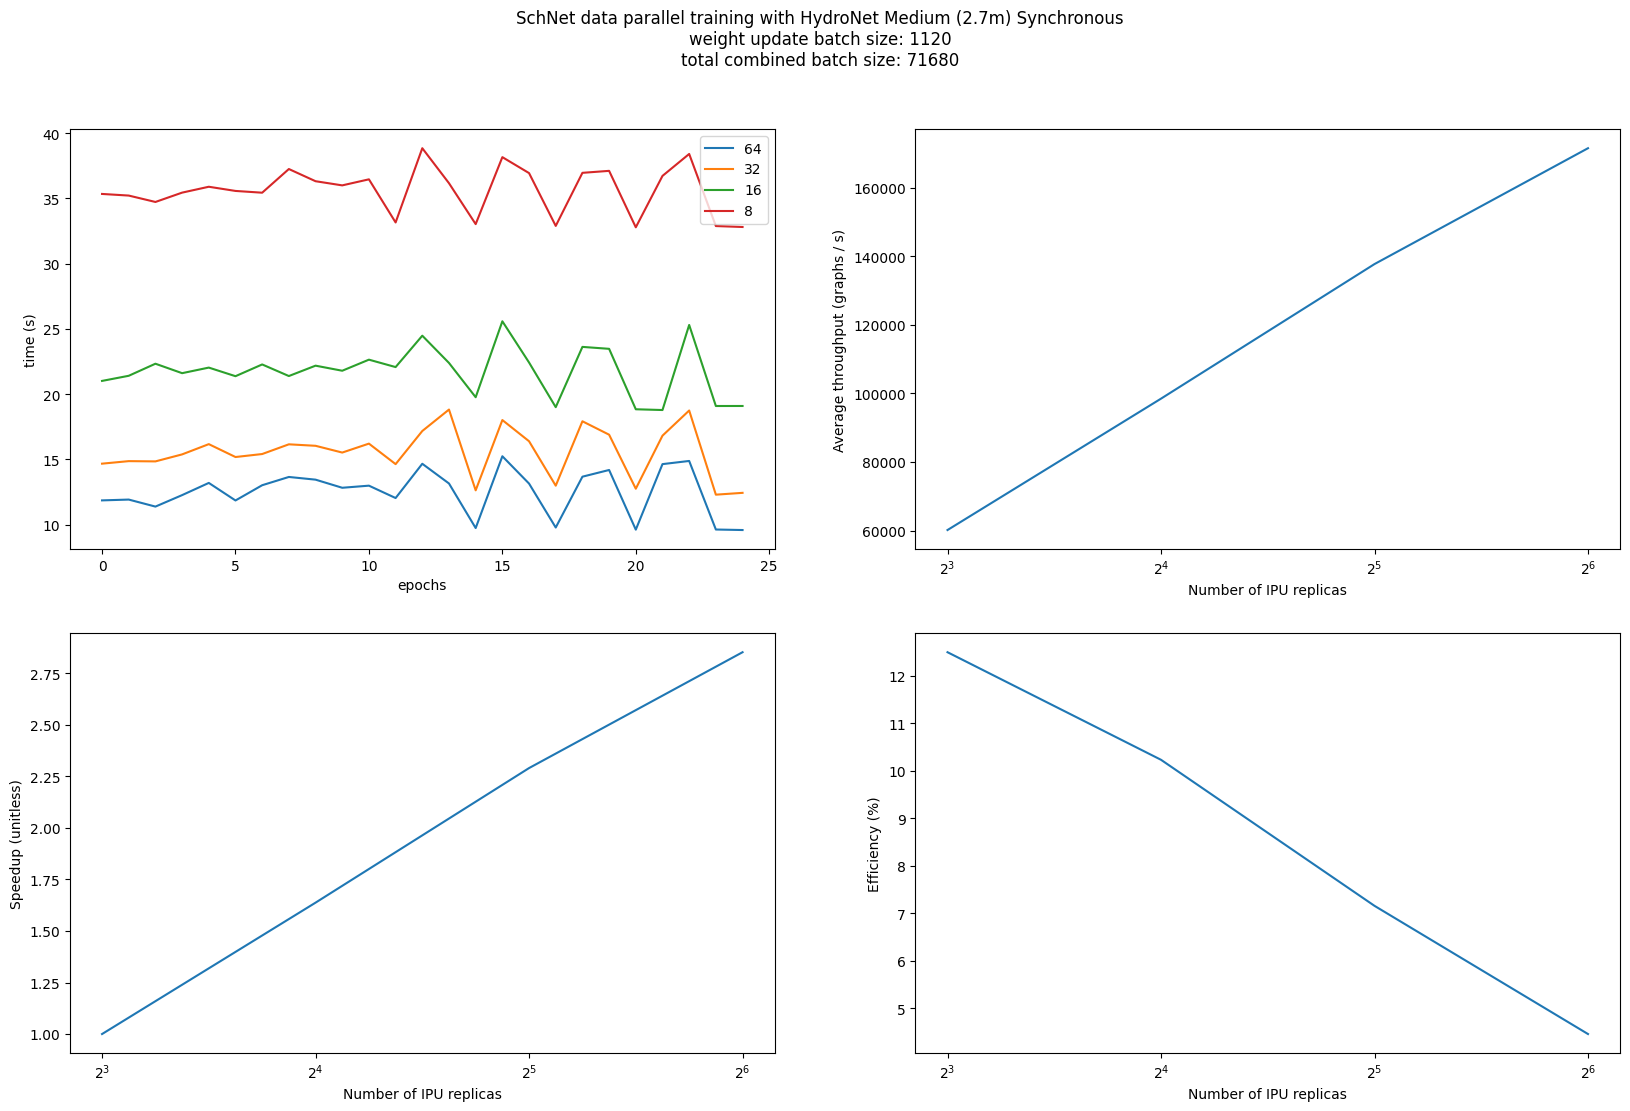

In [54]:
make_plots(df, throughput_df, "HydroNet Medium (2.7m) Synchronous")

## HydroNet Large (4.5m) with Synchronous Data Loading

In [55]:
df, throughput_df, loss_df = sweep_dataframe(
    "hatemh/hydronet-large-bow-sync/sweeps/rssyv7co"
)
df

,64,32,16,8
0,21.230924,24.935567,36.238546,61.234170
1,24.496263,27.156519,39.561248,65.042791
2,25.050624,28.085414,39.209612,66.319189
3,23.529100,27.314333,40.268040,66.156070
4,21.938736,25.324083,35.845708,62.901006
5,18.403032,23.821707,36.777892,62.520862
6,30.527840,30.315185,47.367176,74.206502
7,20.533349,22.559508,34.353478,59.522924
8,21.266339,25.843028,38.641707,63.586195
9,20.114902,22.127926,33.874340,59.857613


In [56]:
throughput_df

,mean_time,N,Throughput (graphs/s),Speedup,Efficiency
64,21.871910,3383900,154714.422653,2.885534,4.508647
32,26.095291,3383900,129674.737926,2.418526,7.557894
16,38.415614,3383900,88086.578034,1.642877,10.267983
8,63.112137,3383900,53617.261876,1.000000,12.500000


In [57]:
loss_df

,64,32,16,8
0,67514.070312,67354.382812,67120.859375,67003.031250
1,67224.640625,67146.132812,67205.109375,67091.804688
2,67249.757812,67060.820312,66874.289062,66682.328125
3,67179.679688,66966.031250,66775.929688,66499.593750
4,67137.796875,66942.617188,66727.257812,66426.351562
5,67127.781250,66950.312500,66814.132812,66681.070312
6,67101.148438,66934.671875,66670.890625,66535.578125
7,67026.695312,66831.984375,66656.726562,66790.070312
8,66942.476562,66719.789062,66557.046875,66475.500000
9,67004.929688,66812.796875,66606.703125,66484.257812


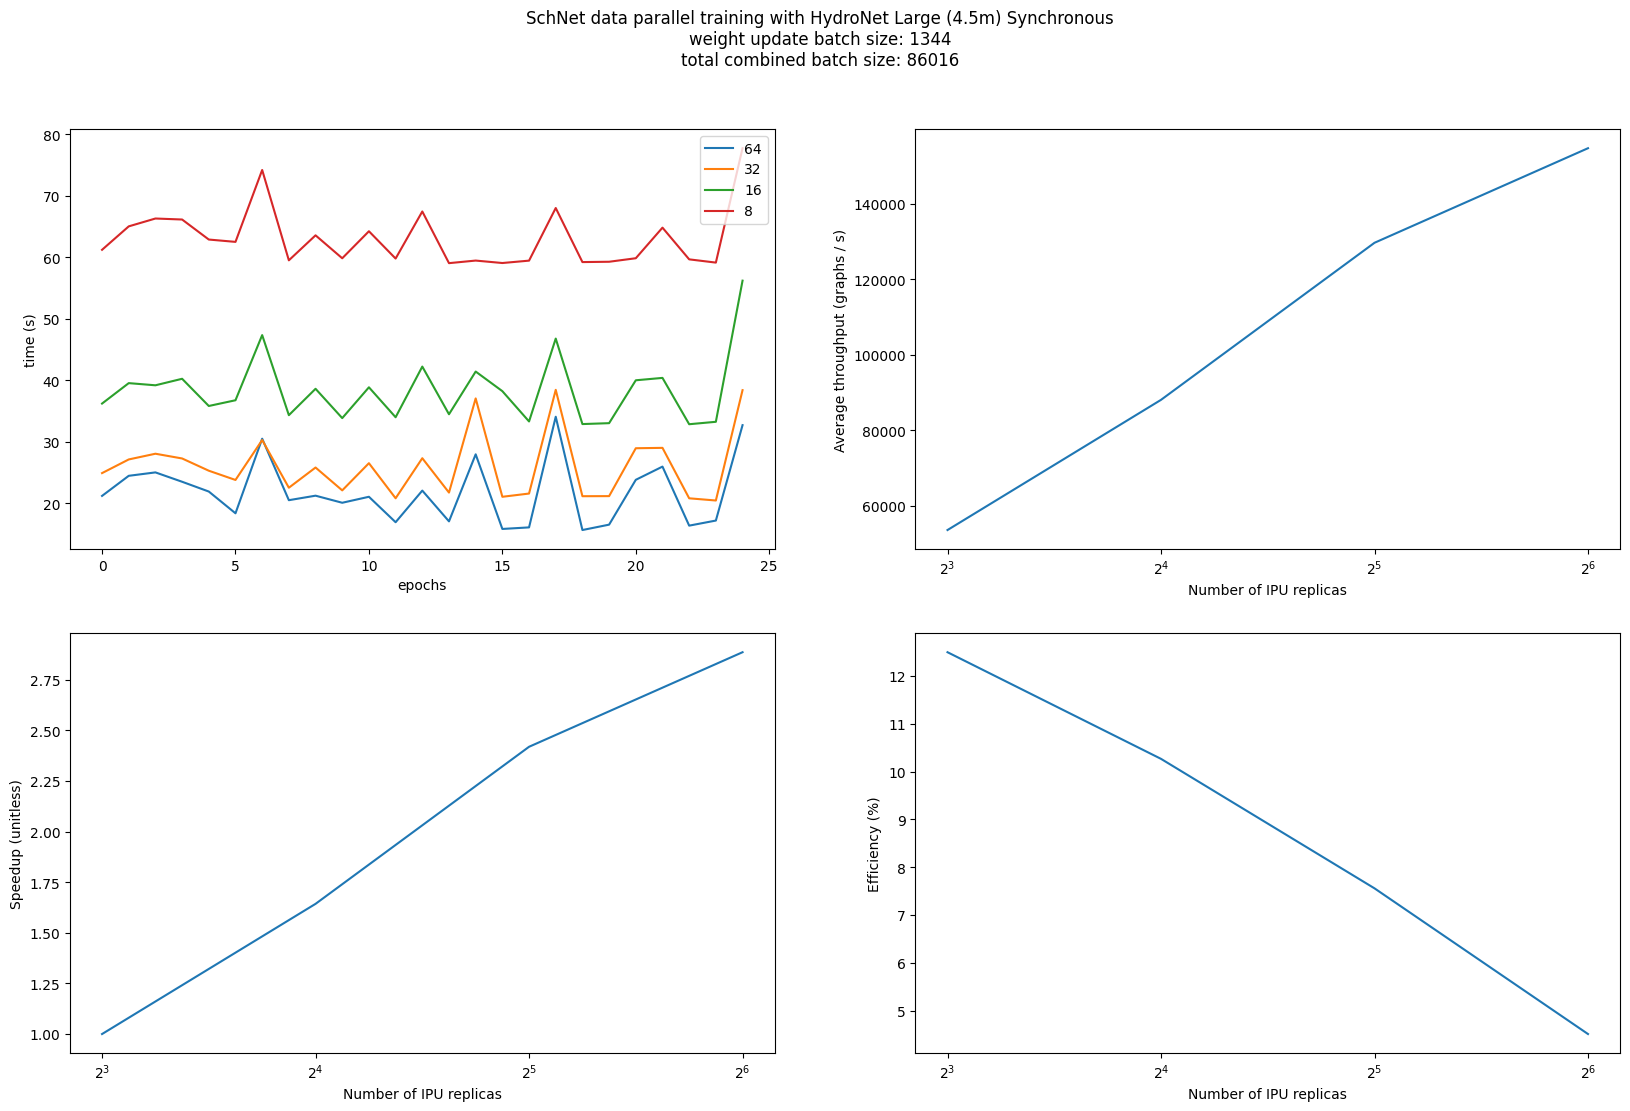

In [58]:
make_plots(df, throughput_df, "HydroNet Large (4.5m) Synchronous")